In [ ]:
# Reload modules automatically.
%load_ext autoreload
%autoreload 2

## 1. Load and preprocess data.

### 1.0 Load necessary global variables and saved data

In [ ]:
import yaml
import pickle
import numpy as np

# reload dict data from pickle files
with open('raw_coord_dict.pkl', 'rb') as f:
    raw_coord_dict = pickle.load(f)
with open('raw_com_dict.pkl', 'rb') as f:
    raw_com_dict = pickle.load(f)
with open('raw_syl_dict.pkl', 'rb') as f:
    raw_syl_dict = pickle.load(f)
with open('lsf_dict.pkl', 'rb') as f:
    lsf_dict = pickle.load(f)

with open('bhvr_kpms_dict.pkl', 'rb') as f:
    bhvr_kpms_dict = pickle.load(f)
with open('bhvr_tuples_dict.pkl', 'rb') as f:
    bhvr_tuples_dict = pickle.load(f)
with open('bhvr_series_dict.pkl', 'rb') as f:
    bhvr_series_dict = pickle.load(f)
with open('nest_tuples_dict.pkl', 'rb') as f:
    nest_tuples_dict = pickle.load(f)
with open('nest_series_dict.pkl', 'rb') as f:
    nest_series_dict = pickle.load(f)
with open('corr_coord_dict.pkl', 'rb') as f:
    corr_coord_dict = pickle.load(f)
with open('simp_coord_dict.pkl', 'rb') as f:
    simp_coord_dict = pickle.load(f)

# Reload config data from yaml file
with open("analyze_data_3d_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

fps = cfg["fps"]
joint_names = cfg["joint_names"]
simp_joint_names = cfg['simp_joint_names']
limb_orders = cfg["limb_orders"]
limb_combos = cfg["limb_combos"]
joint_creds = cfg["joint_creds"]
skel_conns = [tuple(pair) for pair in cfg["skel_conns"]]
simp_skel_conns = [tuple(pair) for pair in cfg["simp_skel_conns"]]
c_maps = cfg["c_maps"]
simp_c_maps = cfg["simp_c_maps"]
bhvr_map = cfg["bhvr_map"]

joint_exclude = cfg["joint_exclude"]
joint_used = [j for j in joint_names if j not in joint_exclude]

### 1.1 Get predicted coordinate data

#### 1.1.1 Get raw coordinate data from .mat files

In [ ]:
from analyze_data_3d_utils.DataLoader import load_coord_data
import pickle

mat_dir = '/home/gxj/Desktop/Synology25/dannce_results/'
raw_coord_dict = load_coord_data(mat_dir, pred_type='pred', check_sess=True)
with open('raw_coord_dict.pkl', 'wb') as f:
    pickle.dump(raw_coord_dict, f)

raw_com_dict = load_coord_data(mat_dir, pred_type='com', check_sess=True)
with open('raw_com_dict.pkl', 'wb') as f:
    pickle.dump(raw_com_dict, f)

#### 1.1.2 Remove outliers and interpolation

In [ ]:
from analyze_data_3d_utils.DataProcessor import find_medoid_distance_outliers, find_RULE_outliers, interpolate_keypoints

corr_coord_dict = {}
for ses_id in raw_coord_dict.keys():
    raw_coords = raw_coord_dict[ses_id].copy()
    outliers = find_medoid_distance_outliers(raw_coords, outlier_scale_factor=6)
    outliers_ = find_RULE_outliers(
        raw_coords, joint_names, limb_orders, skel_conns, joint_creds, 
        prev_outliers=outliers, outlier_scale_factors={'velocity': 5, 'angle': 5, 'displacement': 5})
    interpolated_dict = interpolate_keypoints(raw_coords, outliers_['mask'])
    corr_coord_dict[ses_id] = interpolated_dict

with open('corr_coord_dict.pkl', 'wb') as f:
    pickle.dump(corr_coord_dict, f)

### 1.4 Delete false-triggered looming trials

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.path import Path

# trigger 区域四个顶点
trigger_coord = np.array([[0, 16.5], [0, 55], [55, 55], [55, 16.5]])
trigger_path = Path(trigger_coord)

# SpineM 坐标在 looming 开始帧是否落在 trigger 区域
spine_idx = joint_names.index('SpineM')
outside_trials = []
trial_rows = []
for sess_id, lsf_list in lsf_dict.items():
    xy = corr_coord_dict[sess_id][:, spine_idx, :2]
    for t_idx, lsf_start in enumerate(lsf_list):
        if lsf_start >= len(xy):
            continue
        pt = xy[lsf_start]
        in_trigger = trigger_path.contains_point(pt)
        trial_id = f"{sess_id}T{t_idx + 1}"
        trial_rows.append({
            'sess_id': sess_id,
            'trial_id': trial_id,
            'lsf_start': lsf_start,
            'x': pt[0],
            'y': pt[1],
            'inside': in_trigger,
        })
        if not in_trigger:
            outside_trials.append(trial_id)

df_trigger_check = pd.DataFrame(trial_rows)
outside_trials_set = set(outside_trials)
lsf_dict_filtered = {}
for sess_id, lsf_list in lsf_dict.items():
    keep_lsfs = []
    for t_idx, lsf_start in enumerate(lsf_list):
        trial_id = f"{sess_id}T{t_idx + 1}"
        if trial_id in outside_trials_set:
            continue
        keep_lsfs.append(lsf_start)
    lsf_dict_filtered[sess_id] = keep_lsfs

print("不在 trigger_coord 内的 trial_id:", outside_trials)
print("过滤后 lsf_dict 示例:", {k: v for k, v in list(lsf_dict_filtered.items())[:2]})

## 2. Visualize data

## 3. Analysis

In [2]:
# Reloaad modules automatically.
%load_ext autoreload
%autoreload 2

## 1. Load and preprocess data.

### 1.0 Load necessary global variables and saved data

In [3]:
import yaml
import pickle
import numpy as np

# reload dict data from pickle files
with open('raw_coord_dict.pkl', 'rb') as f:
    raw_coord_dict = pickle.load(f)
with open('raw_com_dict.pkl', 'rb') as f:
    raw_com_dict = pickle.load(f)
with open('raw_syl_dict.pkl', 'rb') as f:
    raw_syl_dict = pickle.load(f)
with open('lsf_dict.pkl', 'rb') as f:
    lsf_dict = pickle.load(f)

with open('bhvr_kpms_dict.pkl', 'rb') as f:
    bhvr_kpms_dict = pickle.load(f)
with open('bhvr_tuples_dict.pkl', 'rb') as f:
    bhvr_tuples_dict = pickle.load(f)
with open('bhvr_series_dict.pkl', 'rb') as f:
    bhvr_series_dict = pickle.load(f)
with open('nest_tuples_dict.pkl', 'rb') as f:
    nest_tuples_dict = pickle.load(f)
with open('nest_series_dict.pkl', 'rb') as f:
    nest_series_dict = pickle.load(f)
with open('corr_coord_dict.pkl', 'rb') as f:
    corr_coord_dict = pickle.load(f)
with open('simp_coord_dict.pkl', 'rb') as f:
    simp_coord_dict = pickle.load(f)

# Reload config data from yaml file
with open("analyze_data_3d_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)


fps = cfg["fps"]
joint_names = cfg["joint_names"]
simp_joint_names = cfg['simp_joint_names']
limb_orders = cfg["limb_orders"]
limb_combos = cfg["limb_combos"]
joint_creds = cfg["joint_creds"]
skel_conns = [tuple(pair) for pair in cfg["skel_conns"]]  # convert to tuples.
simp_skel_conns = [tuple(pair) for pair in cfg["simp_skel_conns"]]
c_maps = cfg["c_maps"]
simp_c_maps = cfg["simp_c_maps"]
bhvr_map = cfg["bhvr_map"]

joint_exclude = cfg["joint_exclude"]
joint_used = [j for j in joint_names if j not in joint_exclude]


### 1.1 Get predicted coordinate data `coord_dict`

#### 1.1.1 Get raw coordinate data `raw_coord_dict` from `.mat` files.

In [ ]:
from analyze_data_3d_utils.DataLoader import load_coord_data
import pickle

mat_dir = '/home/gxj/Desktop/Synology25/dannce_results/'
raw_coord_dict = load_coord_data(mat_dir, pred_type='pred', check_sess=True)
with open('raw_coord_dict.pkl', 'wb') as f:
    pickle.dump(raw_coord_dict, f)

raw_com_dict = load_coord_data(mat_dir, pred_type='com', check_sess=True)
with open('raw_com_dict.pkl', 'wb') as f:
    pickle.dump(raw_com_dict, f)

# data structure
# coord_dict = {'ses_id': np.array of shape (n_frames, n_joints, 3), ...}


Number of pred sessions: 205
['G1M1D1', 'G1M1D2', 'G1M1D3', 'G1M1D4', 'G1M1D5']
['G1M2D1', 'G1M2D2', 'G1M2D3', 'G1M2D4', 'G1M2D5']
['G1M3D1', 'G1M3D2', 'G1M3D3', 'G1M3D4', 'G1M3D5']
['G1M4D1', 'G1M4D2', 'G1M4D3', 'G1M4D4', 'G1M4D5']
['G1M5D1', 'G1M5D2', 'G1M5D3', 'G1M5D4', 'G1M5D5']
['G1M6D1', 'G1M6D2', 'G1M6D3', 'G1M6D4', 'G1M6D5']
['G1M7D1', 'G1M7D2', 'G1M7D3', 'G1M7D4', 'G1M7D5']
['G2M1D1', 'G2M1D2', 'G2M1D3', 'G2M1D4', 'G2M1D5']
['G2M2D1', 'G2M2D2', 'G2M2D3', 'G2M2D4', 'G2M2D5']
['G2M3D1', 'G2M3D2', 'G2M3D3', 'G2M3D4', 'G2M3D5']
['G2M4D1', 'G2M4D2', 'G2M4D3', 'G2M4D4', 'G2M4D5']
['G2M5D1', 'G2M5D2', 'G2M5D3', 'G2M5D4', 'G2M5D5']
['G2M6D1', 'G2M6D2', 'G2M6D3', 'G2M6D4', 'G2M6D5']
['G3M1D1', 'G3M1D2', 'G3M1D3', 'G3M1D4', 'G3M1D5']
['G3M2D1', 'G3M2D2', 'G3M2D3', 'G3M2D4', 'G3M2D5']
['G3M3D1', 'G3M3D2', 'G3M3D3', 'G3M3D4', 'G3M3D5']
['G3M4D1', 'G3M4D2', 'G3M4D3', 'G3M4D4', 'G3M4D5']
['G3M5D1', 'G3M5D2', 'G3M5D3', 'G3M5D4', 'G3M5D5']
['G3M6D1', 'G3M6D2', 'G3M6D3', 'G3M6D4', 'G3M6D5']
['

#### 1.1.2 Remove the outliers and linear interpolation. Get `corr_coordict`.

In [5]:
from analyze_data_3d_utils.DataProcessor import find_medoid_distance_outliers, find_RULE_outliers, interpolate_keypoints

corr_coord_dict = {}
for ses_id in raw_coord_dict.keys():
    raw_coords = raw_coord_dict[ses_id].copy()
    outliers = find_medoid_distance_outliers(raw_coords, outlier_scale_factor=6)
    # joint_creds = {joint: n_outliers for joint, n_outliers in zip(joint_names, outliers['mask'].sum(axis=0))}
    outliers_ = find_RULE_outliers(
        raw_coords, joint_names, limb_orders, skel_conns, joint_creds, 
        prev_outliers=outliers, outlier_scale_factors={'velocity': 5, 'angle': 5, 'displacement': 5})
    interpolated_dict = interpolate_keypoints(raw_coords, outliers_['mask'])
    corr_coord_dict[ses_id] = interpolated_dict

with open('corr_coord_dict.pkl', 'wb') as f:
    pickle.dump(corr_coord_dict, f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
from analyze_data_3d_utils.DataProcessor import simplify_coord_dict

simp_coord_dict, simp_joint_names = simplify_coord_dict(
    corr_coord_dict, joint_names, limb_combos
)
with open('simp_coord_dict.pkl', 'wb') as f:
    pickle.dump(simp_coord_dict, f)
print(simp_coord_dict[list(simp_coord_dict.keys())[0]].shape)


(60313, 15, 3)


In [ ]:
from analyze_data_3d_utils.SkelVisualizer import draw_mean_skeleton
# visualize mean skeleton to check correction effect.
# all_coords = np.concatenate(list(raw_coord_dict.values()), axis=0)
draw_mean_skeleton(corr_coord_dict['G1M1D1'], joint_names, skel_conns)
draw_mean_skeleton(raw_coord_dict['G1M1D1'], joint_names, skel_conns)

### 1.2 Get the predicted behavior data `bhvr_dict`.

#### 1.2.1 Get syllabel data `raw_syl_dict` from `results.h5` file.

In [3]:
import pickle
import numpy as np
from analyze_data_3d_utils.DataLoader import load_syl_data
syl_h5_path = '/home/gxj/Desktop/gxj/kpms_project/state-100_kappa-1e6/results.h5'
syl_dir =  '/home/gxj/Desktop/gxj/kpms_project/state-100_kappa-1e6/results'
prefix = '-home-gxj-Desktop-Synology25-dannce_results-'
suffix = '-save_data_AVG0.csv'

raw_syl_dict = load_syl_data(syl_dir, prefix, suffix, check_sess=True)
with open('raw_syl_dict.pkl', 'wb') as f:
    pickle.dump(raw_syl_dict, f)

# Data structure:
# syl_dict = {'ses_id': np.array of shape (n_frames, ), ...}, where each element is an integer syllable label.

Number of syllabel sessions: 205
['G1M1D1', 'G1M1D2', 'G1M1D3', 'G1M1D4', 'G1M1D5']
['G1M2D1', 'G1M2D2', 'G1M2D3', 'G1M2D4', 'G1M2D5']
['G1M3D1', 'G1M3D2', 'G1M3D3', 'G1M3D4', 'G1M3D5']
['G1M4D1', 'G1M4D2', 'G1M4D3', 'G1M4D4', 'G1M4D5']
['G1M5D1', 'G1M5D2', 'G1M5D3', 'G1M5D4', 'G1M5D5']
['G1M6D1', 'G1M6D2', 'G1M6D3', 'G1M6D4', 'G1M6D5']
['G1M7D1', 'G1M7D2', 'G1M7D3', 'G1M7D4', 'G1M7D5']
['G2M1D1', 'G2M1D2', 'G2M1D3', 'G2M1D4', 'G2M1D5']
['G2M2D1', 'G2M2D2', 'G2M2D3', 'G2M2D4', 'G2M2D5']
['G2M3D1', 'G2M3D2', 'G2M3D3', 'G2M3D4', 'G2M3D5']
['G2M4D1', 'G2M4D2', 'G2M4D3', 'G2M4D4', 'G2M4D5']
['G2M5D1', 'G2M5D2', 'G2M5D3', 'G2M5D4', 'G2M5D5']
['G2M6D1', 'G2M6D2', 'G2M6D3', 'G2M6D4', 'G2M6D5']
['G3M1D1', 'G3M1D2', 'G3M1D3', 'G3M1D4', 'G3M1D5']
['G3M2D1', 'G3M2D2', 'G3M2D3', 'G3M2D4', 'G3M2D5']
['G3M3D1', 'G3M3D2', 'G3M3D3', 'G3M3D4', 'G3M3D5']
['G3M4D1', 'G3M4D2', 'G3M4D3', 'G3M4D4', 'G3M4D5']
['G3M5D1', 'G3M5D2', 'G3M5D3', 'G3M5D4', 'G3M5D5']
['G3M6D1', 'G3M6D2', 'G3M6D3', 'G3M6D4', 'G3M6D5'

In [5]:
# Save raw_syl_dict to check in deepethogram.
from analyze_data_3d_utils.DataProcessor import convert_bhvr_kpms2series, save_bhvr_dicts

syl_series_dict = convert_bhvr_kpms2series(raw_syl_dict)
save_folder = '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output'
save_bhvr_dicts(syl_series_dict, save_folder, save_format='csv', file_prefix='state-100_kappa-1e6_')

Saved 205 files to /home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output


['/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M1D1_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M1D2_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M1D3_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M1D4_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M1D5_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M2D1_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M2D2_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M2D3_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M2D4_labels.csv',
 '/home/gxj/Desktop/gxj/code/lst_3d_code/bhvr_series_output/state-100_kappa-1e6_G1M2D5_labels.csv',


In [31]:
# Find syllabel indexes.
sess_id = 'G1M1D1'
syllable_num = 1
idx = np.where(raw_syl_dict[sess_id] == syllable_num)[0]
print(idx.tolist())

[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 115, 116, 117, 118, 119, 120, 202, 203, 204, 205, 206, 207, 208, 209, 210, 306, 307, 308, 309, 310, 311, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 716, 717, 718, 719, 835, 836, 837, 838, 839, 840, 841, 842, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 943, 944, 945, 946, 947, 948, 949, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 1216, 1217, 1218, 1219, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 2120, 2121, 2122, 2123, 2124, 2125, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2323, 2324, 2325, 2326, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 

#### 1.2.2 Map `syl_dict` to `bhvr_dict` based on `bhvr_map`.

In [4]:
import numpy as np
import pickle
from analyze_data_3d_utils.DataProcessor import map_syllabel_to_behavior

# Map syllable labels to behavior names
bhvr_kpms_dict = map_syllabel_to_behavior(raw_syl_dict, bhvr_map)

# Save to pickle file
with open('bhvr_kpms_dict.pkl', 'wb') as f:
    pickle.dump(bhvr_kpms_dict, f)

# Print statistics for verification
print(f"\nExample session {list(bhvr_kpms_dict.keys())[0]}:")
unique_bhvr, counts = np.unique(bhvr_kpms_dict[list(bhvr_kpms_dict.keys())[0]], return_counts=True)
total = len(bhvr_kpms_dict[list(bhvr_kpms_dict.keys())[0]])
for bhvr, count in zip(unique_bhvr, counts):
    print(f"  {bhvr}: {count} frames ({count/total:.2%})")


Example session G1M1D1:
  complete_rearing: 4289 frames (7.11%)
  grooming: 1488 frames (2.47%)
  grooming_sliding_onnest: 605 frames (1.00%)
  head_raising: 911 frames (1.51%)
  immobile: 6746 frames (11.18%)
  immobile_curling: 193 frames (0.32%)
  immobile_twisting: 480 frames (0.80%)
  incomplete_rearing: 8595 frames (14.25%)
  other: 272 frames (0.45%)
  rearing_onnest: 176 frames (0.29%)
  slightly_mobile: 4744 frames (7.87%)
  supported_rearing: 69 frames (0.11%)
  trotting: 676 frames (1.12%)
  twisting_grooming_1frame_onnest: 22 frames (0.04%)
  twisting_grooming_onnest: 14 frames (0.02%)
  twisting_grooming_rearing_onnest: 531 frames (0.88%)
  twisting_onnest: 365 frames (0.61%)
  walking: 17143 frames (28.42%)
  walking_exploring: 11572 frames (19.19%)
  walking_exploring_onnest: 1422 frames (2.36%)


#### 1.2.3 Get 'in_nest_zone' state.

In [67]:
import pickle
import pandas as pd
from analyze_data_3d_utils.DataProcessor import convert_bhvr_series2tuples

# Create nest_series_dict to store nest zone information
nest_coord = np.array([[0, 0], [0, 22.65], [16.23, 22.65], [16.23, 0]])
xmin, ymin = nest_coord.min(axis=0)
xmax, ymax = nest_coord.max(axis=0)

nest_series_dict = {}
for sess_id in bhvr_series_dict.keys():
    nest_series_dict[sess_id] = {}
    coord_data = simp_coord_dict[sess_id]
    bhvr_data = bhvr_series_dict[sess_id]
    xy = coord_data[:, 4, :2]
    x = xy[:, 0]
    y = xy[:, 1]
    in_nest = (
        (x >= xmin) & (x <= xmax) &
        (y >= ymin) & (y <= ymax)
    )
    nest_series = pd.Series(
        in_nest.astype(int),
        index=bhvr_data[next(iter(bhvr_data))].index,
        name='nest'
    )
    nest_series_dict[sess_id]['nest'] = nest_series

nest_tuples_dict = convert_bhvr_series2tuples(nest_series_dict)
# Save to pickle file
with open('nest_series_dict.pkl', 'wb') as f:
    pickle.dump(nest_series_dict, f)
with open('nest_tuples_dict.pkl', 'wb') as f:
    pickle.dump(nest_tuples_dict, f)


#### 1.2.4 Refine `bhvr_kpms_dict` using position and speed rules

In [59]:
import numpy as np

def refine_behaviors_with_kinematics(
    bhvr_dict,
    coord_dict,
    fps,
    nest_coord,
    running_speed_thresh=20,
    running_min_frames=3,
    freezing_speed_thresh=1,
    freezing_min_frames=3,
):
    spine_idx = joint_names.index('SpineM')
    snout_idx = joint_names.index('Snout')
    nest_min = nest_coord.min(axis=0)
    nest_max = nest_coord.max(axis=0)

    def _compute_speed(coords, joint_idx):
        xy = coords[:, joint_idx, :2]
        disp = np.diff(xy, axis=0, prepend=xy[[0]])
        return np.linalg.norm(disp, axis=1) * fps

    def _mark_sustained(mask, min_len):
        keep = np.zeros_like(mask, dtype=bool)
        start = None
        for i, flag in enumerate(mask):
            if flag and start is None:
                start = i
            if not flag and start is not None:
                if i - start >= min_len:
                    keep[start:i] = True
                start = None
        if start is not None and len(mask) - start >= min_len:
            keep[start:] = True
        return keep

    def _apply_onnest(labels, coords):
        x = coords[:, spine_idx, 0]
        y = coords[:, spine_idx, 1]
        z_spine = coords[:, spine_idx, 2]
        z_snout = coords[:, snout_idx, 2]
        in_nest = (
            (x >= nest_min[0]) & (x <= nest_max[0]) &
            (y >= nest_min[1]) & (y <= nest_max[1])
        )
        keep_mask = in_nest & (z_spine >= 5) & (z_snout >= 6)
        out = labels.copy()
        for i, lbl in enumerate(out):
            if lbl.endswith('_onnest') and not keep_mask[i]:
                out[i] = lbl.rsplit('_onnest', 1)[0]
        return out

    def _apply_running(labels, coords):
        speed = _compute_speed(coords, spine_idx)
        sustained = _mark_sustained(speed > running_speed_thresh, running_min_frames)
        out = labels.copy()
        for i, lbl in enumerate(out):
            if sustained[i]:
                out[i] = 'running' + ('_onnest' if lbl.endswith('_onnest') else '')
        return out

    def _apply_freezing(labels, coords):
        speed_spine = _compute_speed(coords, spine_idx)
        speed_snout = _compute_speed(coords, snout_idx)
        # cond = (speed_spine < freezing_speed_thresh) & (speed_snout < freezing_speed_thresh)
        cond = (speed_spine < freezing_speed_thresh)
        sustained = _mark_sustained(cond, freezing_min_frames)
        immobile_set = {'immobile', 'immobile_curling', 'immobile_twisting', 'slightly_mobile', 'walking_exploring'}
        out = labels.copy()
        for i, lbl in enumerate(out):
            base = lbl.replace('_onnest', '')
            if base in immobile_set and sustained[i]:
                out[i] = 'freezing' + ('_onnest' if lbl.endswith('_onnest') else '')
        return out

    refined = {}
    for sess_id, labels in bhvr_dict.items():
        coords = coord_dict[sess_id]
        labels_arr = np.array(labels, dtype=object)
        labels_arr = _apply_onnest(labels_arr, coords)
        labels_arr = _apply_running(labels_arr, coords)
        labels_arr = _apply_freezing(labels_arr, coords)
        refined[sess_id] = labels_arr
    return refined

nest_coord = np.array([[0, 0], [0, 22.65], [16.23, 22.65], [16.23, 0]])
bhvr_kpms_dict_refined = refine_behaviors_with_kinematics(
    bhvr_kpms_dict,
    corr_coord_dict,
    fps,
    nest_coord,
)

#### 1.2.5 Convert `bhvr_kpms_dict` to series and tuples format for further analysis.

In [60]:
from analyze_data_3d_utils.DataProcessor import convert_bhvr_kpms2series, convert_bhvr_series2tuples

bhvr_series_dict = convert_bhvr_kpms2series(bhvr_kpms_dict_refined)
bhvr_tuples_dict = convert_bhvr_series2tuples(bhvr_series_dict)

with open('bhvr_tuples_dict.pkl', 'wb') as f:
    pickle.dump(bhvr_tuples_dict, f)
with open('bhvr_series_dict.pkl', 'wb') as f:
    pickle.dump(bhvr_series_dict, f)

### 1.3 Get looming start frame `lsf_dict` from `.csv` file.

In [6]:
import pickle
from analyze_data_3d_utils.DataLoader import load_lsf_csv

lst_csv_path = '/home/gxj/Desktop/gxj/code/lst_3d_code/lst_3d_result.csv'
lsf_dict = load_lsf_csv(lst_csv_path, check_sess=True)

with open('lsf_dict.pkl', 'wb') as f:
    pickle.dump(lsf_dict, f)

Number of looming start frame sessions: 205
['G1M1D1', 'G1M1D2', 'G1M1D3', 'G1M1D4', 'G1M1D5']
['G1M2D1', 'G1M2D2', 'G1M2D3', 'G1M2D4', 'G1M2D5']
['G1M3D1', 'G1M3D2', 'G1M3D3', 'G1M3D4', 'G1M3D5']
['G1M4D1', 'G1M4D2', 'G1M4D3', 'G1M4D4', 'G1M4D5']
['G1M5D1', 'G1M5D2', 'G1M5D3', 'G1M5D4', 'G1M5D5']
['G1M6D1', 'G1M6D2', 'G1M6D3', 'G1M6D4', 'G1M6D5']
['G1M7D1', 'G1M7D2', 'G1M7D3', 'G1M7D4', 'G1M7D5']
['G2M1D1', 'G2M1D2', 'G2M1D3', 'G2M1D4', 'G2M1D5']
['G2M2D1', 'G2M2D2', 'G2M2D3', 'G2M2D4', 'G2M2D5']
['G2M3D1', 'G2M3D2', 'G2M3D3', 'G2M3D4', 'G2M3D5']
['G2M4D1', 'G2M4D2', 'G2M4D3', 'G2M4D4', 'G2M4D5']
['G2M5D1', 'G2M5D2', 'G2M5D3', 'G2M5D4', 'G2M5D5']
['G2M6D1', 'G2M6D2', 'G2M6D3', 'G2M6D4', 'G2M6D5']
['G3M10D1', 'G3M10D2', 'G3M10D3', 'G3M10D4', 'G3M10D5']
['G3M11D1', 'G3M11D2', 'G3M11D3', 'G3M11D4', 'G3M11D5']
['G3M1D1', 'G3M1D2', 'G3M1D3', 'G3M1D4', 'G3M1D5']
['G3M2D1', 'G3M2D2', 'G3M2D3', 'G3M2D4', 'G3M2D5']
['G3M3D1', 'G3M3D2', 'G3M3D3', 'G3M3D4', 'G3M3D5']
['G3M4D1', 'G3M4D2', 'G3M4D3

### 1.4 Delete false-triggered_looming_trials.

In [18]:
import numpy as np
import pandas as pd
from matplotlib.path import Path

# trigger 区域四个顶点（闭合多边形用第一个点自动闭合）
trigger_coord = np.array([[0, 16.5], [0, 55], [55, 55], [55, 16.5]])
trigger_path = Path(trigger_coord)

# SpineM 坐标在 looming 开始帧是否落在 trigger 区域
spine_idx = joint_names.index('SpineM')
outside_trials = []
all_trials = []
trial_rows = []
for sess_id, lsf_list in lsf_dict.items():
    xy = corr_coord_dict[sess_id][:, spine_idx, :2]
    for t_idx, lsf_start in enumerate(lsf_list):
        if lsf_start >= len(xy):
            # lsf 超出坐标长度，跳过
            trial_rows.append({
                'sess_id': sess_id,
                'trial_id': f"{sess_id}T{t_idx + 1}",
                'lsf_start': lsf_start,
                'x': np.nan,
                'y': np.nan,
                'inside': np.nan,
            })
            continue
        pt = xy[lsf_start]
        in_trigger = trigger_path.contains_point(pt)
        trial_id = f"{sess_id}T{t_idx + 1}"
        trial_rows.append({
            'sess_id': sess_id,
            'trial_id': trial_id,
            'lsf_start': lsf_start,
            'x': pt[0],
            'y': pt[1],
            'inside': in_trigger,
        })
        if not in_trigger:
            outside_trials.append(trial_id)
        all_trials.append(trial_id)

df_trigger_check = pd.DataFrame(trial_rows)
outside_trials_set = set(outside_trials)
lsf_dict_filtered = {}
for sess_id, lsf_list in lsf_dict.items():
    keep_lsfs = []
    for t_idx, lsf_start in enumerate(lsf_list):
        trial_id = f"{sess_id}T{t_idx + 1}"
        if trial_id in outside_trials_set:
            continue
        keep_lsfs.append(lsf_start)
    lsf_dict_filtered[sess_id] = keep_lsfs

print(len(outside_trials))
print(len(all_trials))

273
1579


## 2. Visualize data.

In [12]:
from analyze_data_3d_utils.SkelVisualizer import visualize_3d, save_frames, visualize_and_save_3d
video_path = '/home/gxj/Desktop/Synology25/merged_video_data/G1M1D1_cam1.avi'
ses_id = 'G1M1D1'
frame_range = (0, 50, 1)  # start, end, step
save_path = '/home/gxj/Desktop/gxj/code/lst_3d_code/output_0_50.mp4'
viz_fps=10

visualize_and_save_3d(
    simp_coord_dict[ses_id],
    frame_range,
    simp_joint_names,
    simp_skel_conns,
    simp_c_maps,
    save_path,
    viz_fps,
    video_path,
    bhvr_kpms_dict[ses_id],
    mode='global'
    )


Start rendering & saving...
Saved to /home/gxj/Desktop/gxj/code/lst_3d_code/output_0_50.mp4


## 3. Analyze coordinate data `coord_dict` and get some features.

#### analyze speed and dist2looming.

In [6]:
from analyze_data_3d_utils.DataAnalyzer import calculate_speed, calculate_distance

# Get speed, distance to looming center for further analysis.
corr_speed_dict = {}
corr_velocity_dict = {}
corr_dist2looming_dict = {}
fps=20  # For simplicity, the global variable fps is a fixed value.
dt = 1/fps
looming_center = [50-14.25, 25.0]  # cm, ignore the z coordinate.
for ses_id, corr_coords in corr_coord_dict.items():  # coords: (n_frames, n_joints, 3)
    n_joints = corr_coords.shape[1]
    corr_velocity_dict[ses_id] = {}
    corr_speed_dict[ses_id] = {}
    corr_dist2looming_dict[ses_id] = {}
    for joint_idx in range(n_joints):
        joint_name = joint_names[joint_idx]
        velocity, speed = calculate_speed(corr_coords, unit='cm/s', joint_idx=joint_idx, exclude_z=True)
        _, dist2looming = calculate_distance(corr_coords, joint_idx=joint_idx, target_point=looming_center, exclude_z=True)
        corr_velocity_dict[ses_id][joint_name] = velocity
        corr_speed_dict[ses_id][joint_name] = speed
        corr_dist2looming_dict[ses_id][joint_name] = dist2looming

raw_velocity_dict = {}
raw_speed_dict = {}
raw_dist2looming_dict = {}
for ses_id, raw_coords in raw_coord_dict.items():  # coords: (n_frames, n_joints, 3)
    n_joints = raw_coords.shape[1]
    raw_velocity_dict[ses_id] = {}
    raw_speed_dict[ses_id] = {}
    raw_dist2looming_dict[ses_id] = {}
    for joint_idx in range(n_joints):
        joint_name = joint_names[joint_idx]
        velocity, speed = calculate_speed(raw_coords, unit='cm/s', joint_idx=joint_idx, exclude_z=True)
        _, dist2looming = calculate_distance(raw_coords, joint_idx=joint_idx, target_point=looming_center, exclude_z=True)
        raw_velocity_dict[ses_id][joint_name] = velocity
        raw_speed_dict[ses_id][joint_name] = speed
        raw_dist2looming_dict[ses_id][joint_name] = dist2looming


[ 0.         16.53686408  5.53096103 ...  3.19074466  2.22486612
  9.22243785] [16.91256718 17.73716383 17.99045966 ... 35.08967832 35.17734385
 35.63469407]


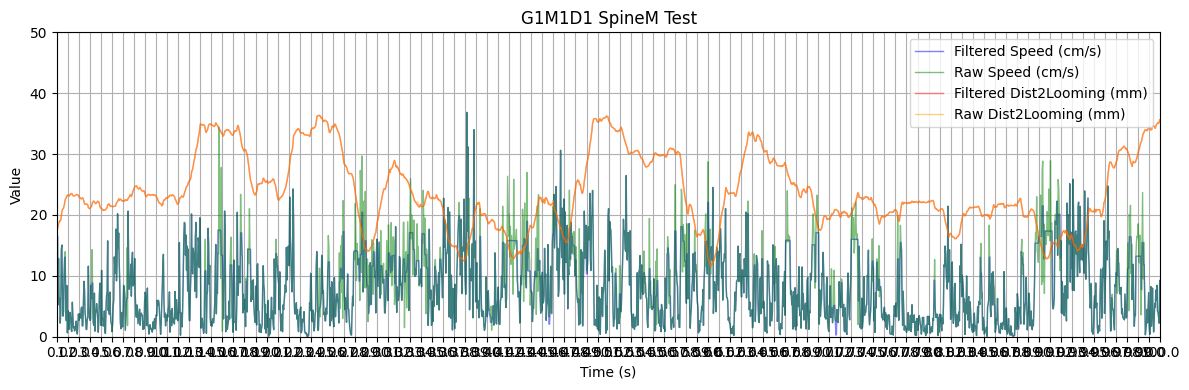

In [ ]:
from analyze_data_3d_utils.DataVisualizer import plot_lines

# Draw speed and dist2looming line plot of all mice.
interest_joints = ['SpineM']
num_mice = len(raw_coord_dict)

for interest_joint in interest_joints:
    for sess_id in [list(raw_coord_dict.keys())[0]]:
        g = int(sess_id[1]) - 1
        # Draw test data for filtering check.
        draw_frames = (0, 2000)
        corr_speed_series = corr_speed_dict[sess_id][interest_joint][draw_frames[0]: draw_frames[1]]
        corr_dist_series = corr_dist2looming_dict[sess_id][interest_joint][draw_frames[0]: draw_frames[1]]
        raw_speed_series = raw_speed_dict[sess_id][interest_joint][draw_frames[0]: draw_frames[1]]
        raw_dist_series = raw_dist2looming_dict[sess_id][interest_joint][draw_frames[0]: draw_frames[1]]
        series_dict = {
            'Filtered Speed (cm/s)': (corr_speed_series, 'blue'),
            'Raw Speed (cm/s)': (raw_speed_series, 'green'),
            'Filtered Dist2Looming (mm)': (corr_dist_series, 'red'),
            'Raw Dist2Looming (mm)': (raw_dist_series, 'orange')
        }
        title_id = f'{sess_id} {interest_joint} Test'
        plot_lines(series_dict, draw_frames, title_id)

In [ ]:
from analyze_data_3d_utils.DataVisualizer import plot_lines

# Draw speed and dist2looming line plot of all mice.
interest_joint = 'SpineM'
num_mice = len(corr_coord_dict)

for sess_id, lsf_list in lsf_dict.items():
    for t_id, lsf in enumerate(lsf_list):
        draw_frames = (lsf-fps*5, lsf+fps*60)
        print(sess_id, t_id, draw_frames)
        speed_series = corr_speed_dict[sess_id][interest_joint]
        dist_series = corr_dist2looming_dict[sess_id][interest_joint]
        series_dict = {
            'Speed (cm/s)': (speed_series, 'blue'),
            'Distance to Looming (mm)': (dist_series, 'red'),
        }
        title_id = f'{sess_id}T{t_id+1}_speed&dist2looming'
        xticks = np.arange(-5, 61, 5)
        save_dir = '/home/gxj/Desktop/gxj/code/lst_3d_code/speed&dist2looming'
        plot_lines(series_dict, draw_frames, title_id, lsf, xticks, save_dir=save_dir)

#### draw speed histogram.

<Figure size 1000x600 with 0 Axes>

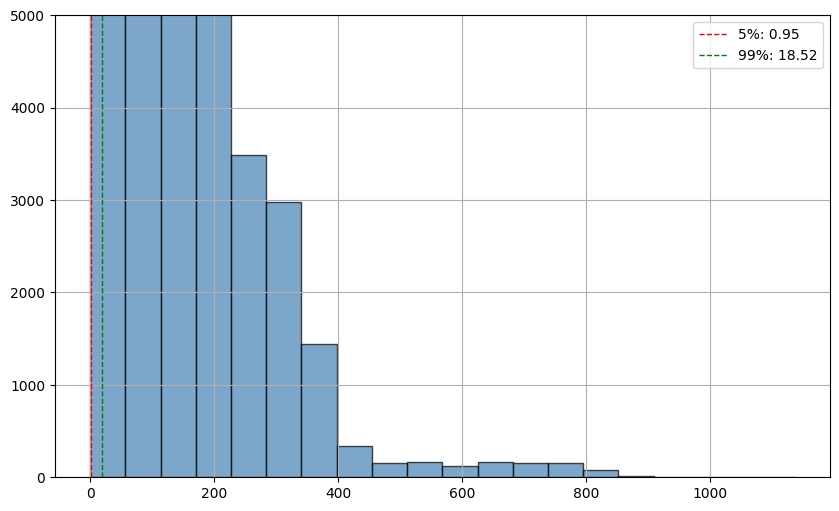

In [57]:
import matplotlib.pyplot as plt

all_speeds = []
for sess_id in corr_speed_dict:
    speed_series = corr_speed_dict[sess_id]['SpineM']
    all_speeds.append(speed_series)
speeds = np.concatenate(all_speeds)

plt.figure(figsize=(10, 6))
p05 = np.quantile(speeds, 0.15)
p99 = np.quantile(speeds, 0.95)
plt.figure(figsize=(10, 6))
plt.hist(speeds, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(p05, color='red', linestyle='--', linewidth=1, label=f'5%: {p05:.2f}')
plt.axvline(p99, color='green', linestyle='--', linewidth=1, label=f'99%: {p99:.2f}',)
plt.ylim(0, 5000)
plt.legend()
plt.grid(True)
plt.show()

#### draw z-coord histogram.

<Figure size 1000x600 with 0 Axes>

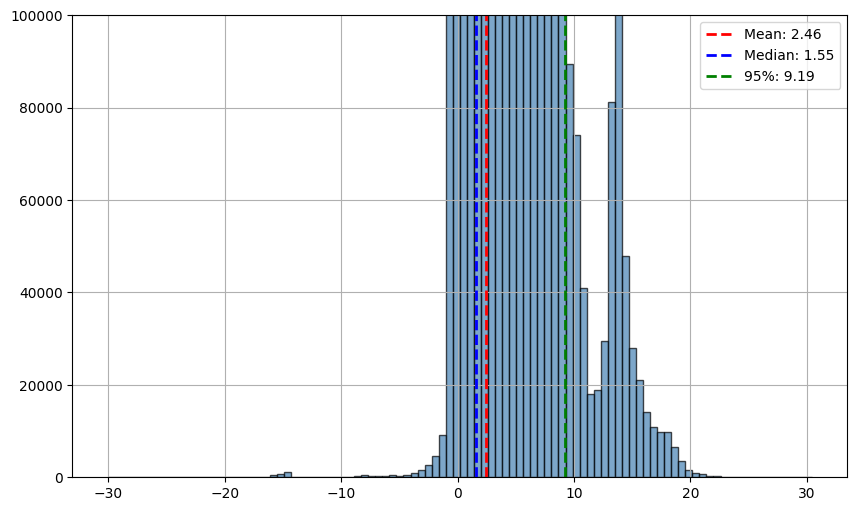

In [27]:
# Draw z-coord histogram to detect rearing.
all_z_coords = []
for m_id in simp_coord_dict:
    spine_idx = simp_joint_names.index('Snout')
    z_series = simp_coord_dict[m_id][:, spine_idx, 2]
    all_z_coords.append(z_series)
z_coords = np.concatenate(all_z_coords)

plt.figure(figsize=(10, 6))
z_mean = np.mean(z_coords)
z_median = np.median(z_coords)
p95 = np.quantile(z_coords, 0.95)
plt.figure(figsize=(10, 6))
plt.hist(z_coords, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(z_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {z_mean:.2f}')
plt.axvline(z_median, color='blue', linestyle='--', linewidth=2, label=f'Median: {z_median:.2f}')
plt.axvline(p95, color='green', linestyle='--', linewidth=2, label=f'95%: {p95:.2f}',)
plt.ylim(0, 1e5)
plt.legend()
plt.grid(True)
plt.show()

#### draw ethogram.

In [ ]:
from analyze_data_3d_utils.DataVisualizer import plot_ethogram
from analyze_data_3d_utils.DataAnalyzer import filter_behavior_in_time_range, sync_start_time

bhvr_params = {
    'running': ('red', 1),
    'trotting': ('darkgray', 1), 
    'walking': ('gray', 1), 
    'head_raising': ('greenyellow', 1), 
    'incomplete_rearing': ('limegreen', 1), 
    'complete_rearing': ('green', 1), 
    'supported_rearing': ('darkgreen', 1),
    'slightly_mobile': ('skyblue', 1), 
    'walking_exploring': ('cyan', 1), 
    'freezing': ('blue', 1),
    'immobile': ('lightblue', 1), 
    'immobile_curling': ('darkblue', 1),
    'immobile_twisting': ('navy', 1),
    'grooming': ('orange', 1), 
    'twisting_grooming_onnest': ('orange', 1), 
    'grooming_sliding_onnest': ('orange', 1), 
    'rearing': ('orange', 1), 
    'twisting_grooming_rearing': ('orange', 1),
    'twisting': ('orange', 1),
    'twisting_grooming_1frame_onnest': ('black', 1), 
    'twisting_grooming_onnest': ('black', 1), 
    'grooming_sliding_onnest': ('black', 1), 
    'rearing_onnest': ('black', 1), 
    'twisting_grooming_rearing_onnest': ('black', 1), 
    'twisting_onnest': ('black', 1), 
    'walking_exploring_onnest': ('black', 1), 
    'other': ('white', 1)
}

# Plot ethogram for each session separately
for g in range(1, 6):
    for m in range(1, 2):
        for d in range(1, 2):
            sess_id = f'G{g}M{m}D{d}'
            if sess_id in lsf_dict:
                bhvr_etho_dict = {}
                nest_etho_dict = {}
                for t, lsf in enumerate(lsf_dict[sess_id]):
                    toi = (lsf - fps*5, lsf + fps*60)
                    bhvr_tuples_sess = filter_behavior_in_time_range({sess_id: bhvr_tuples_dict[sess_id]}, toi)
                    nest_tuples_sess = filter_behavior_in_time_range({sess_id: nest_tuples_dict[sess_id]}, toi)
                    sync_toi = (lsf, lsf + fps*60)
                    bhvr_tuples_sync = sync_start_time(bhvr_tuples_sess, sync_toi)
                    nest_tuples_sync = sync_start_time(nest_tuples_sess, sync_toi)
                    bhvr_etho_dict[f'{sess_id}T{t+1}'] = bhvr_tuples_sync[sess_id]
                    nest_etho_dict[f'{sess_id}T{t+1}'] = nest_tuples_sync[sess_id]
                
                # Plot ethogram for this session
                plot_ethogram(
                    bhvr_etho_dict, 
                    nest_etho_dict,
                    bhvr_params, 
                    draw_frames=(-200, 1400),
                    lsf=0, 
                    title=f'ethogram_{sess_id}', 
                    save_dir='/home/gxj/Desktop/gxj/code/lst_3d_code/ethogram'
                )


#### decision-making analysis.

In [19]:
def calculate_all_looming_decisions(sess_id, bhvr_tuples_dict_sess, lsf_list, fps=20):
    """
    Calculate decisions for all looming stimuli across all trials in a session.
    
    Args:
        sess_id: str, session ID like 'G1M1D1'
        bhvr_tuples_dict_sess: dict, behavior tuples for the session 
                               {behavior_name: [(start, end), ...]}
        lsf_list: list of int, looming stimulus frame starts for each trial
        fps: int, frames per second
    
    Returns:
        dict with trial_id as key and decisions dict as value
        e.g., {'G1M1D1T1': {0: 'F', 1: 'E', ...}, 'G1M1D1T2': {...}, ...}
    """
    blank_time_list = [0, 0.5, 1, 3, 0]  # seconds
    looming_rep_list = [5, 5, 5, 5, 1]
    
    # Extract g from session_id
    g = int(sess_id.split('G')[1].split('M')[0])
    
    blank_time = blank_time_list[g - 1]
    looming_rep = looming_rep_list[g - 1]
    
    # Define behavior categories
    freeze_behaviors = ['freezing', 'immobile', 'immobile_curling', 'immobile_twisting', 'slightly_mobile', 'walking_exploring']
    escape_behaviors = ['running']
    rear_behaviors = ['head_raising', 'incomplete_rearing', 'complete_rearing', 'supported_rearing']
    
    all_trial_decisions = {}
    
    # Process each trial
    for t_idx, lsf in enumerate(lsf_list):
        trial_id = f'{sess_id}T{t_idx + 1}'
        decisions = []
        
        for looming_id in range(looming_rep):
            lsf_start = lsf + looming_id * (0.75 + blank_time) * fps
            lsf_end = lsf_start + 0.75 * fps
            looming_end = lsf_end + blank_time * fps
            
            # Check which behaviors occur during this looming period
            has_freeze = False
            has_escape = False
            has_rear = False
            
            for bhvr_name, bhvr_list in bhvr_tuples_dict_sess.items():
                for start_frame, end_frame in bhvr_list:
                    # Check if behavior overlaps with looming period [lsf_start, looming_end]
                    if start_frame < looming_end and end_frame > lsf_start:
                        if any(bhvr_name.startswith(b) for b in freeze_behaviors):
                            has_freeze = True
                        elif any(bhvr_name.startswith(b) for b in escape_behaviors):
                            has_escape = True
                        elif any(bhvr_name.startswith(b) for b in rear_behaviors):
                            has_rear = True
            
            # Determine decision based on behavior combination
            if has_freeze and not has_escape:
                decision = 'F'
            elif has_freeze and has_escape:
                decision = 'F+E'
            elif has_escape and not has_freeze:
                decision = 'E'
            elif has_rear and not has_escape and not has_freeze:
                decision = 'R'
            else:
                decision = 'I'
            
            decisions.append(decision)
        
        all_trial_decisions[trial_id] = decisions
    
    return all_trial_decisions


deci_looming_dict = {}
for sess_id in lsf_dict.keys():
    result = calculate_all_looming_decisions(
        sess_id, 
        bhvr_tuples_dict[sess_id], 
        lsf_dict_filtered[sess_id]
    )
    deci_looming_dict[sess_id] = result

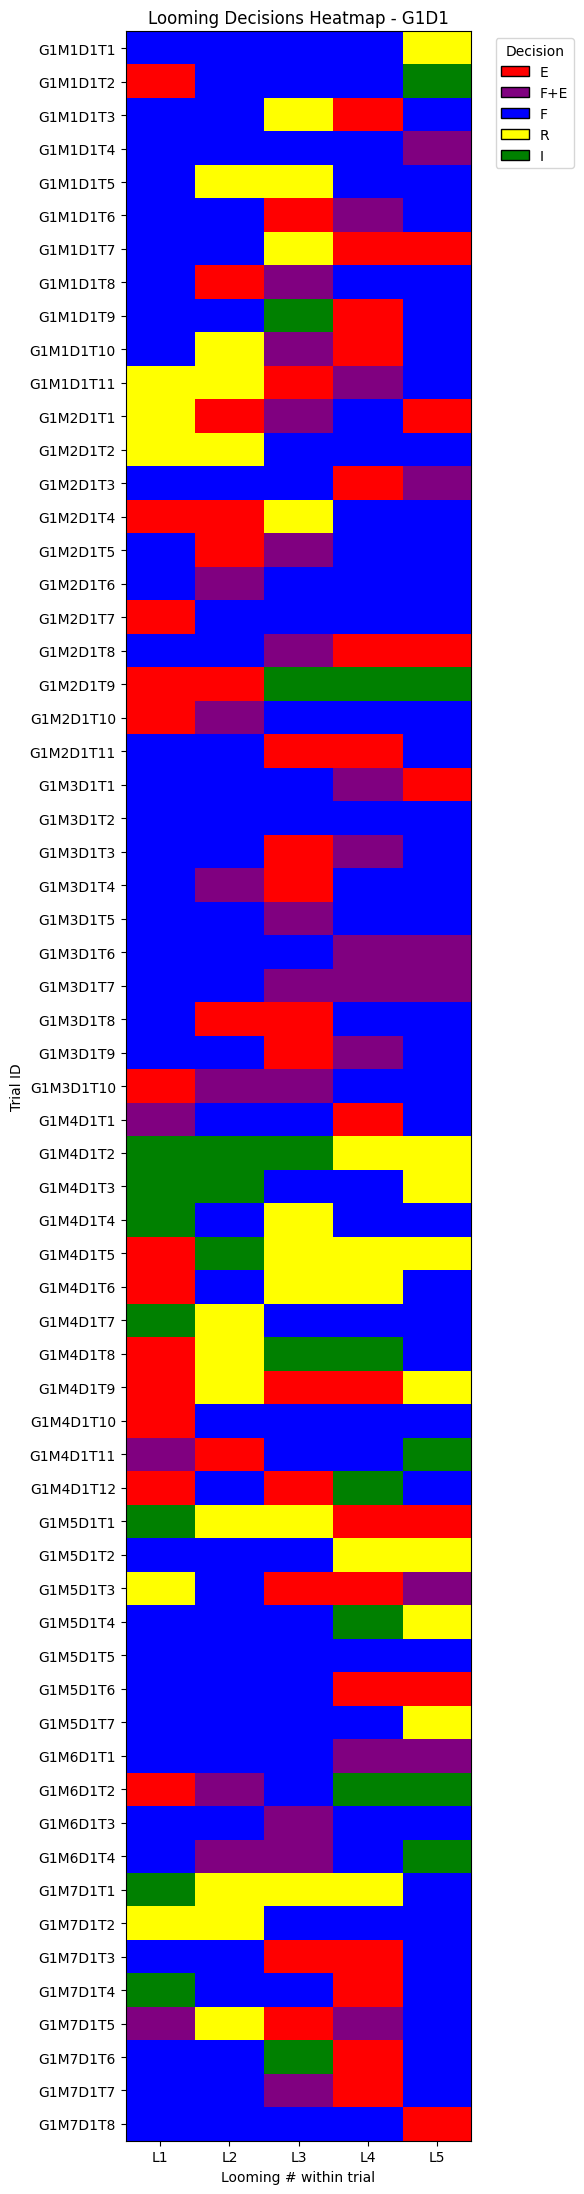

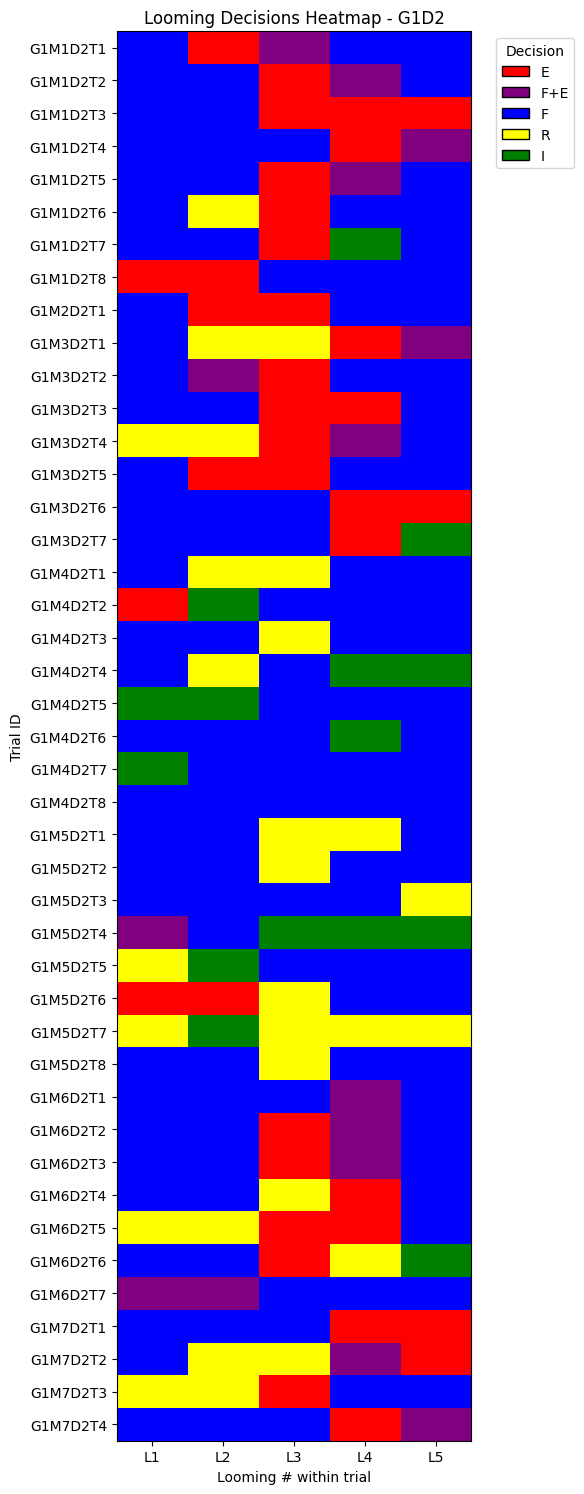

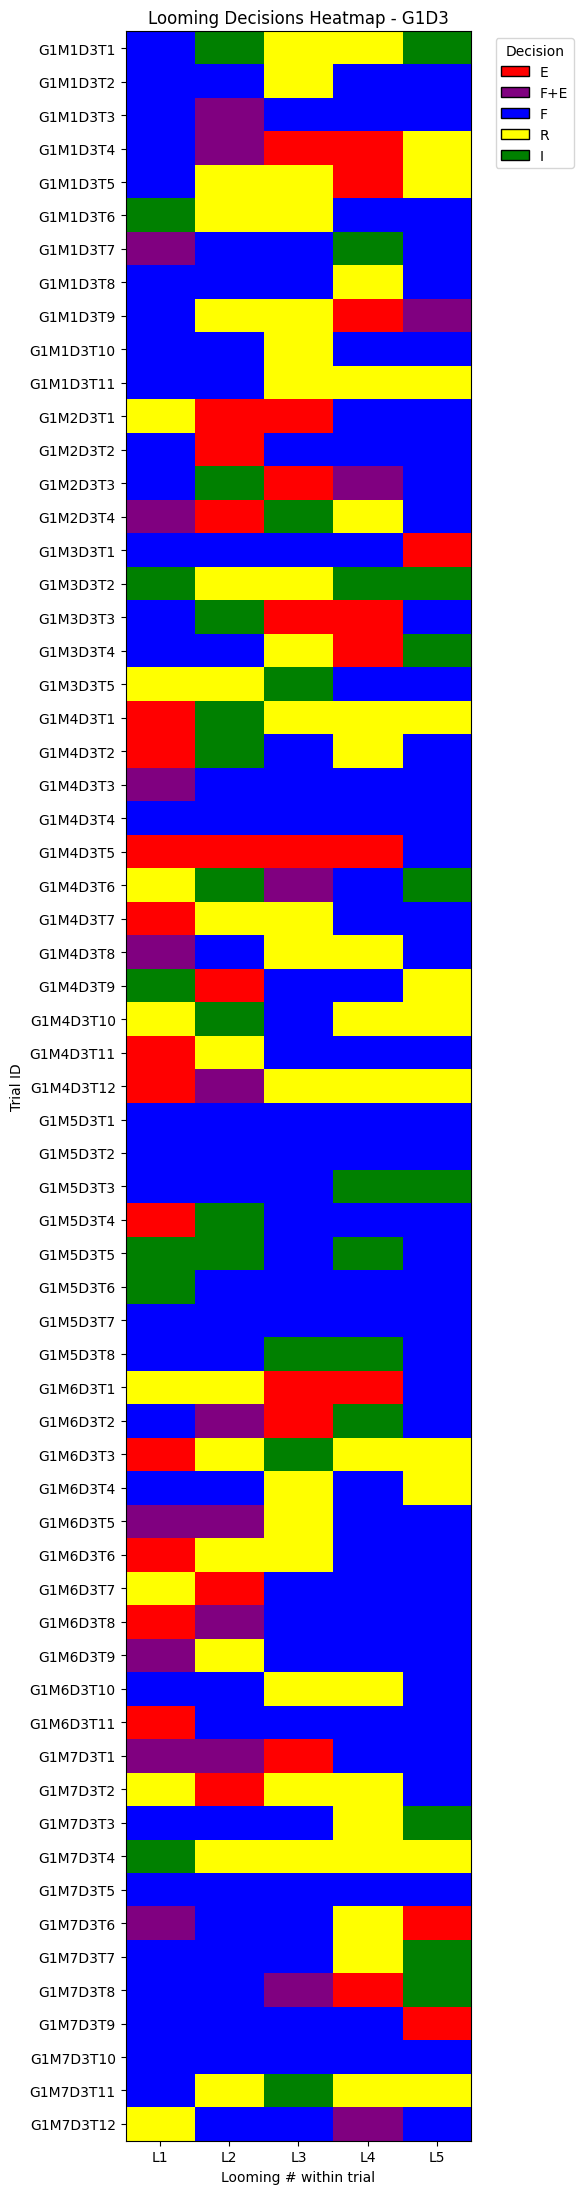

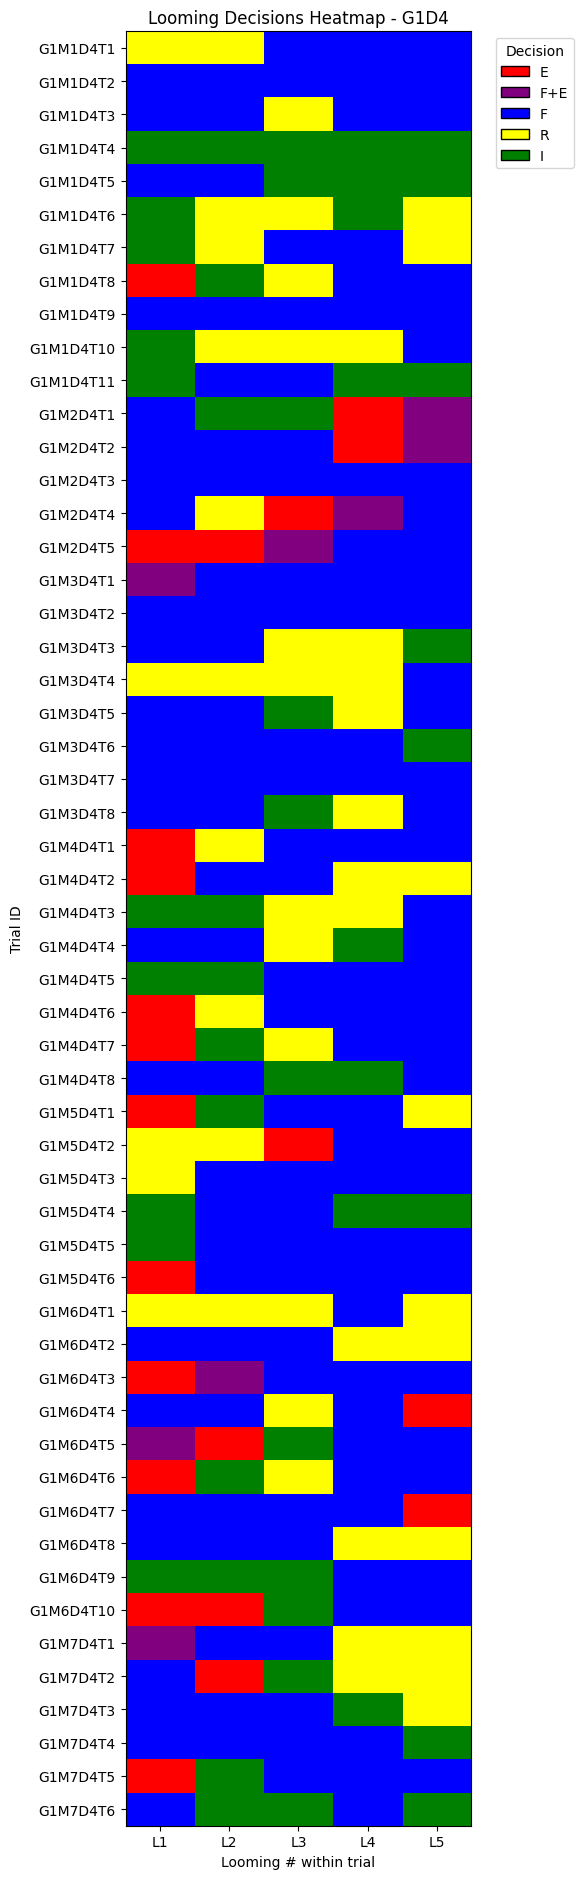

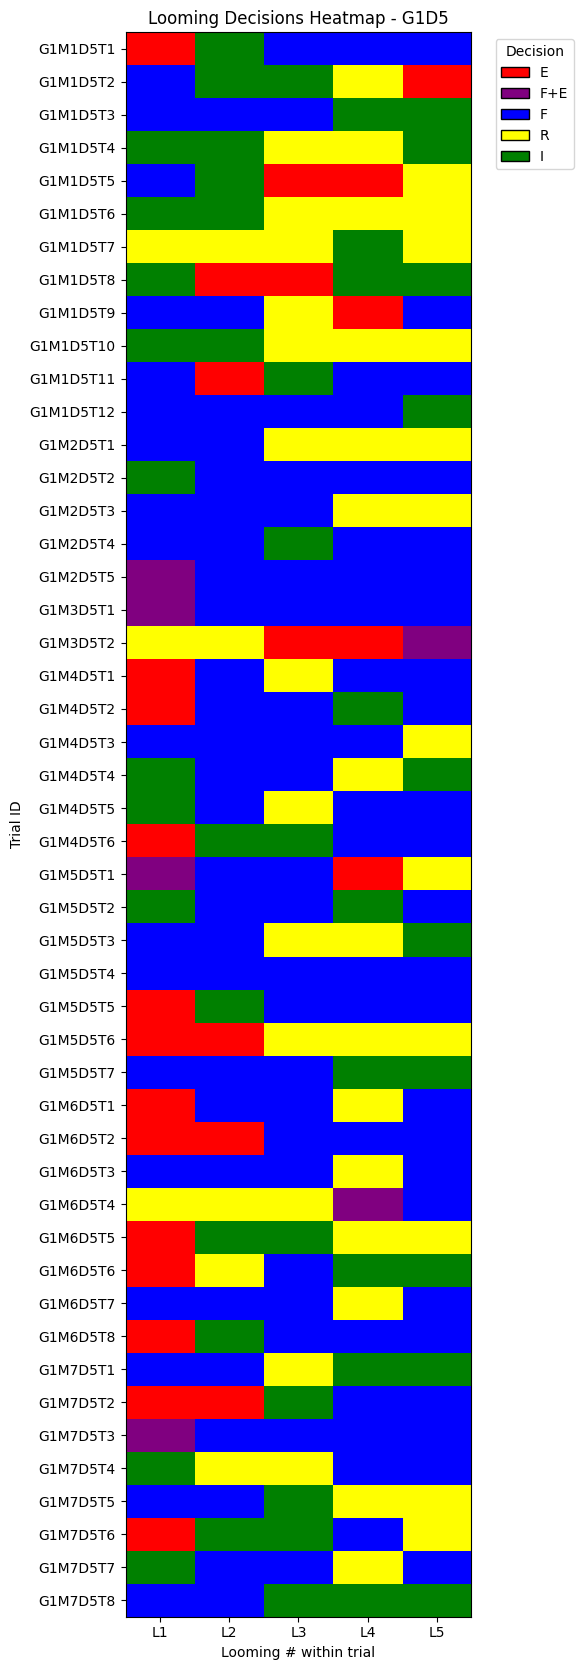

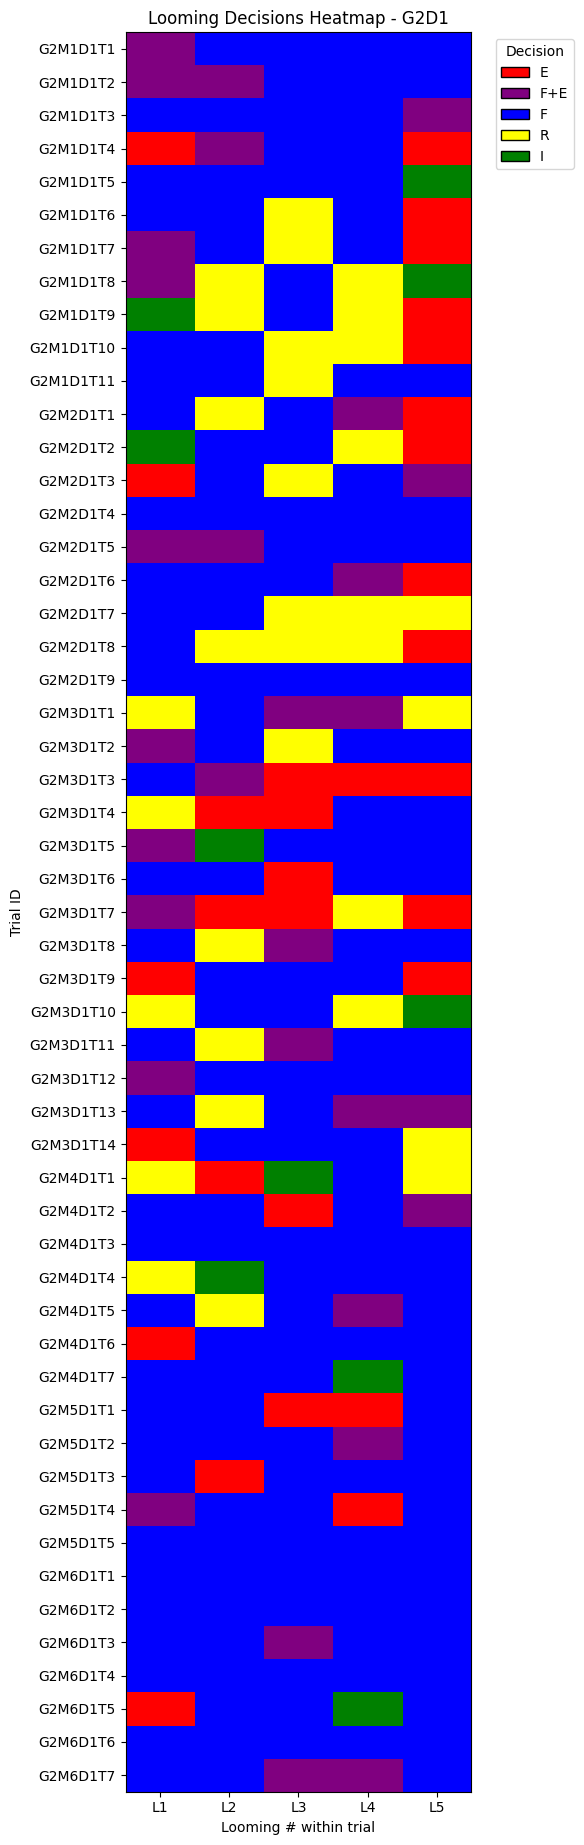

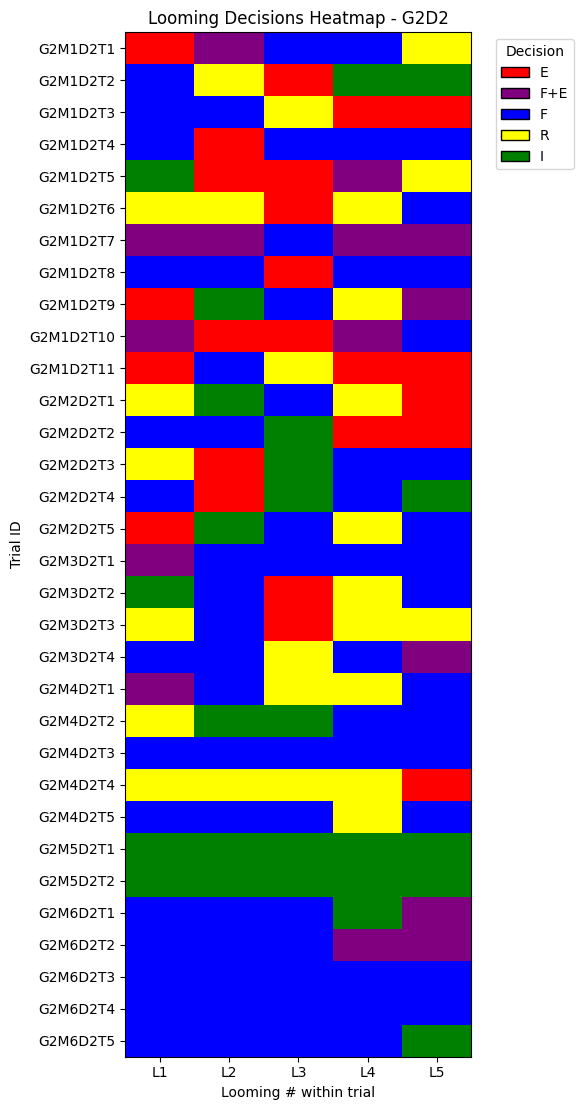

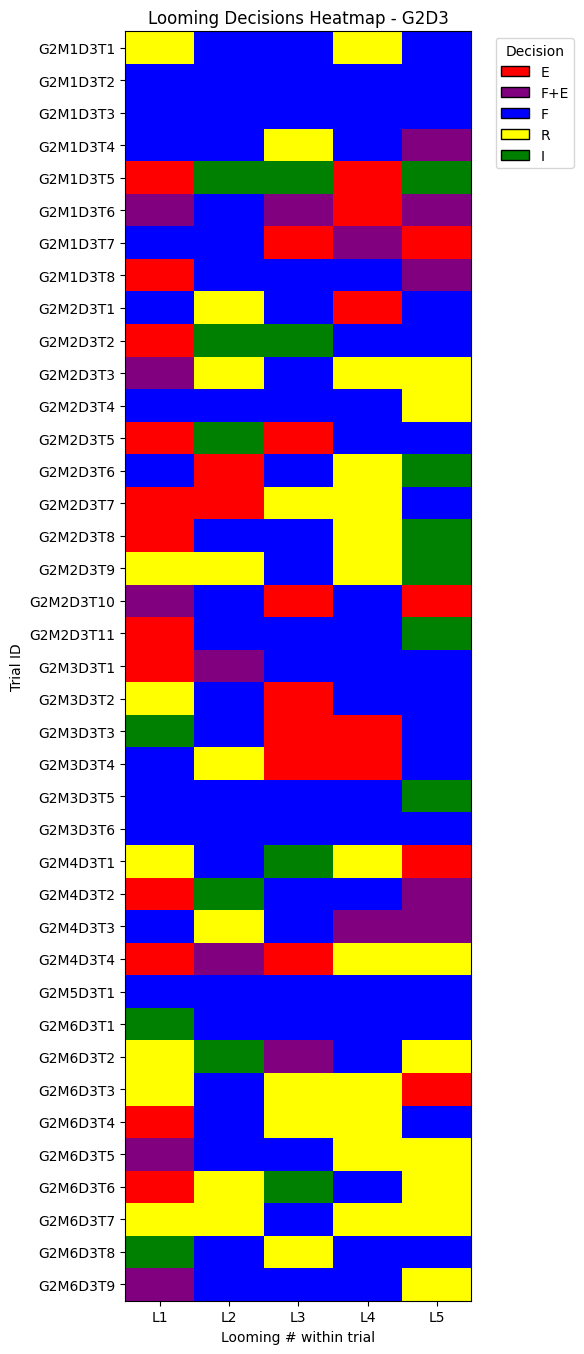

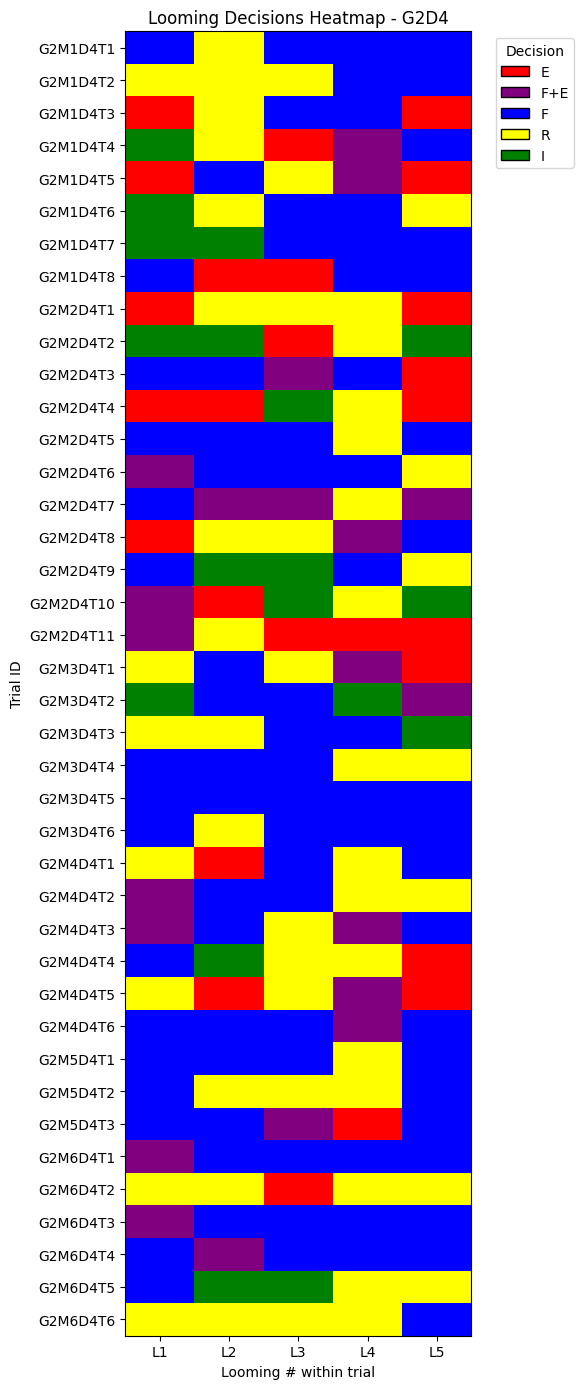

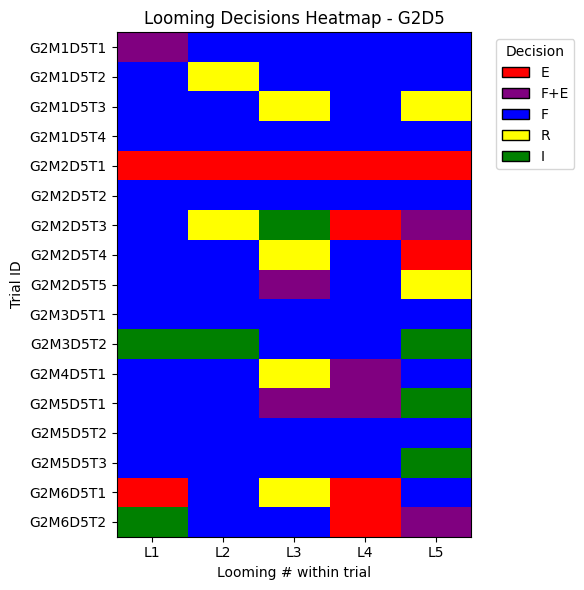

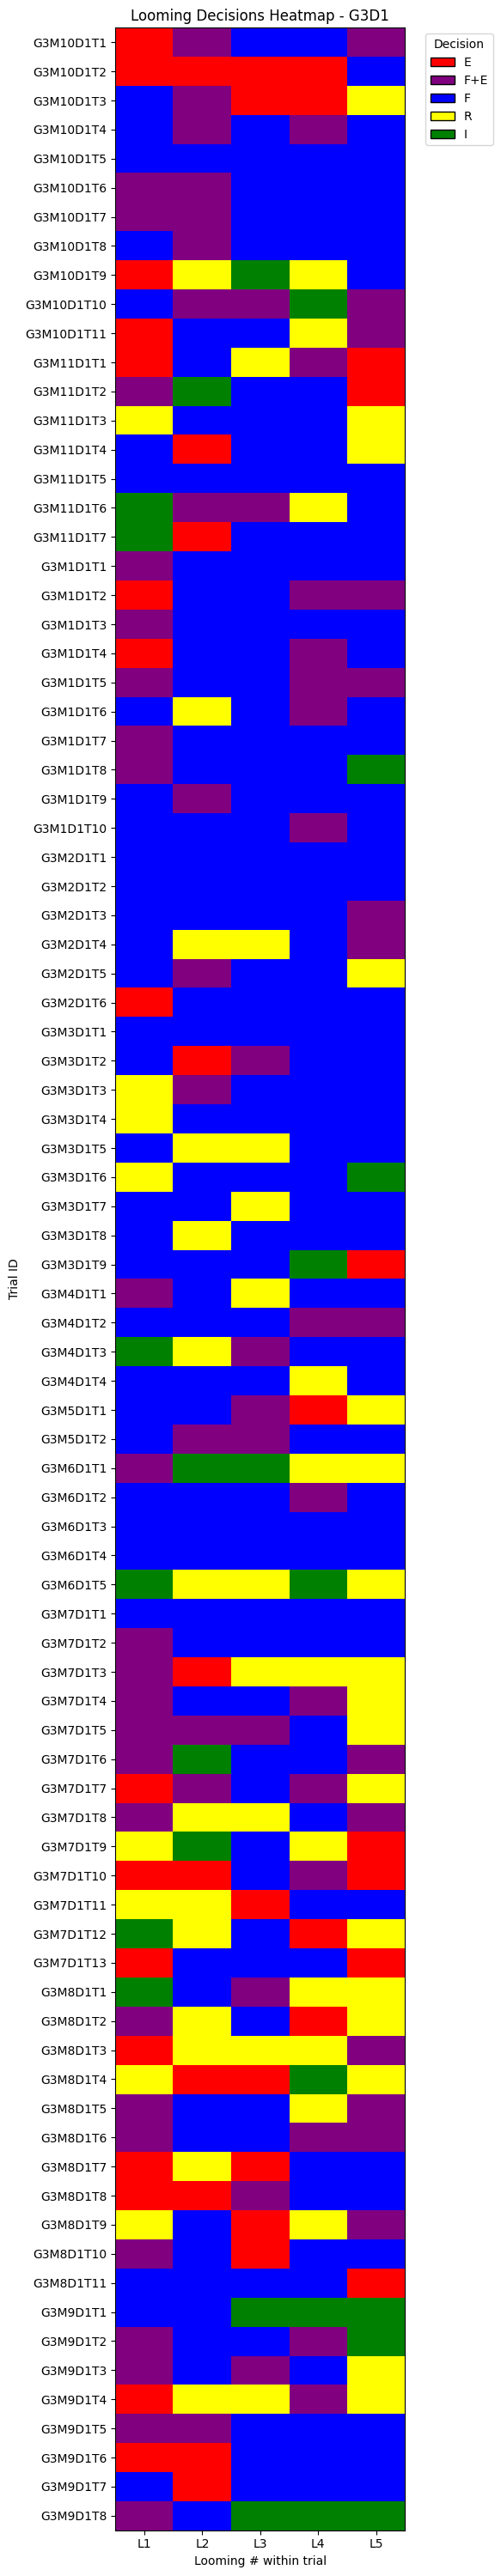

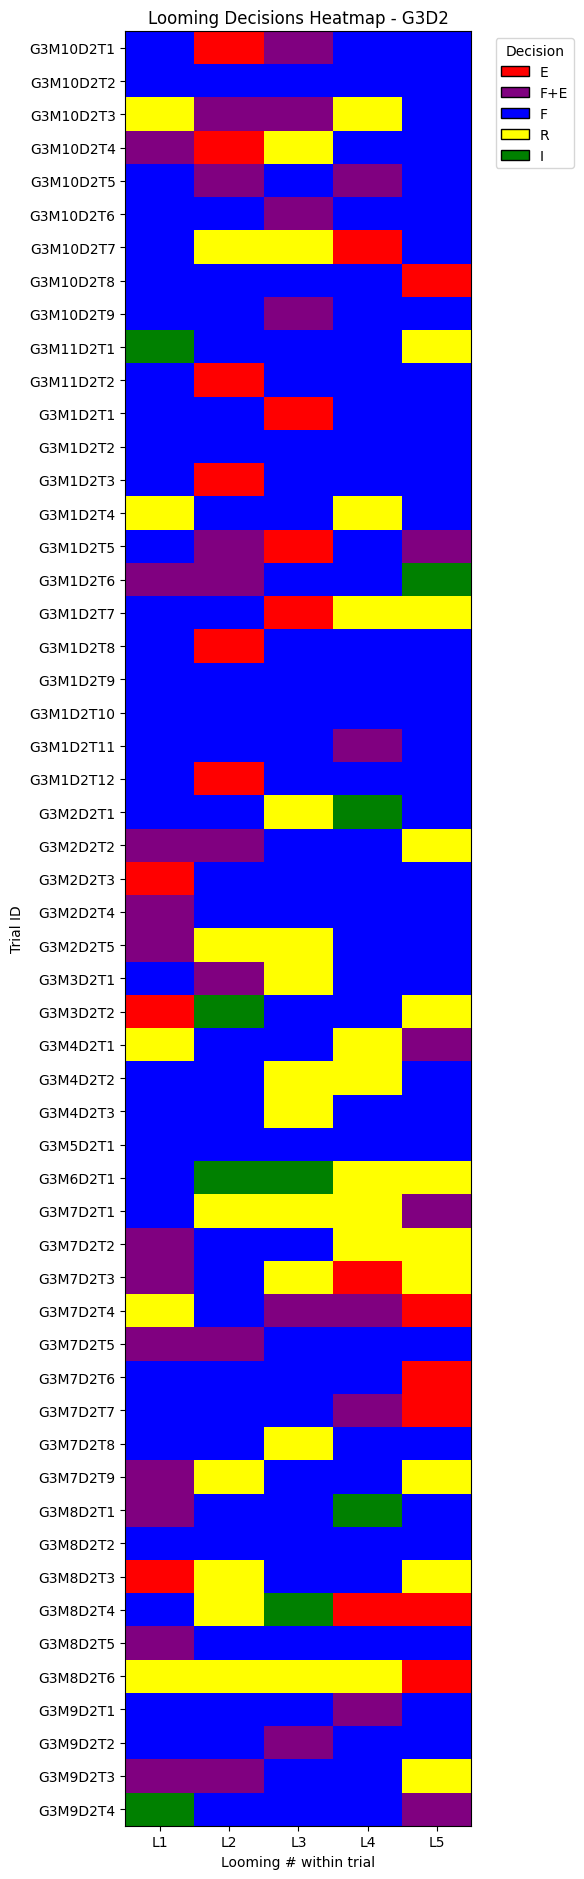

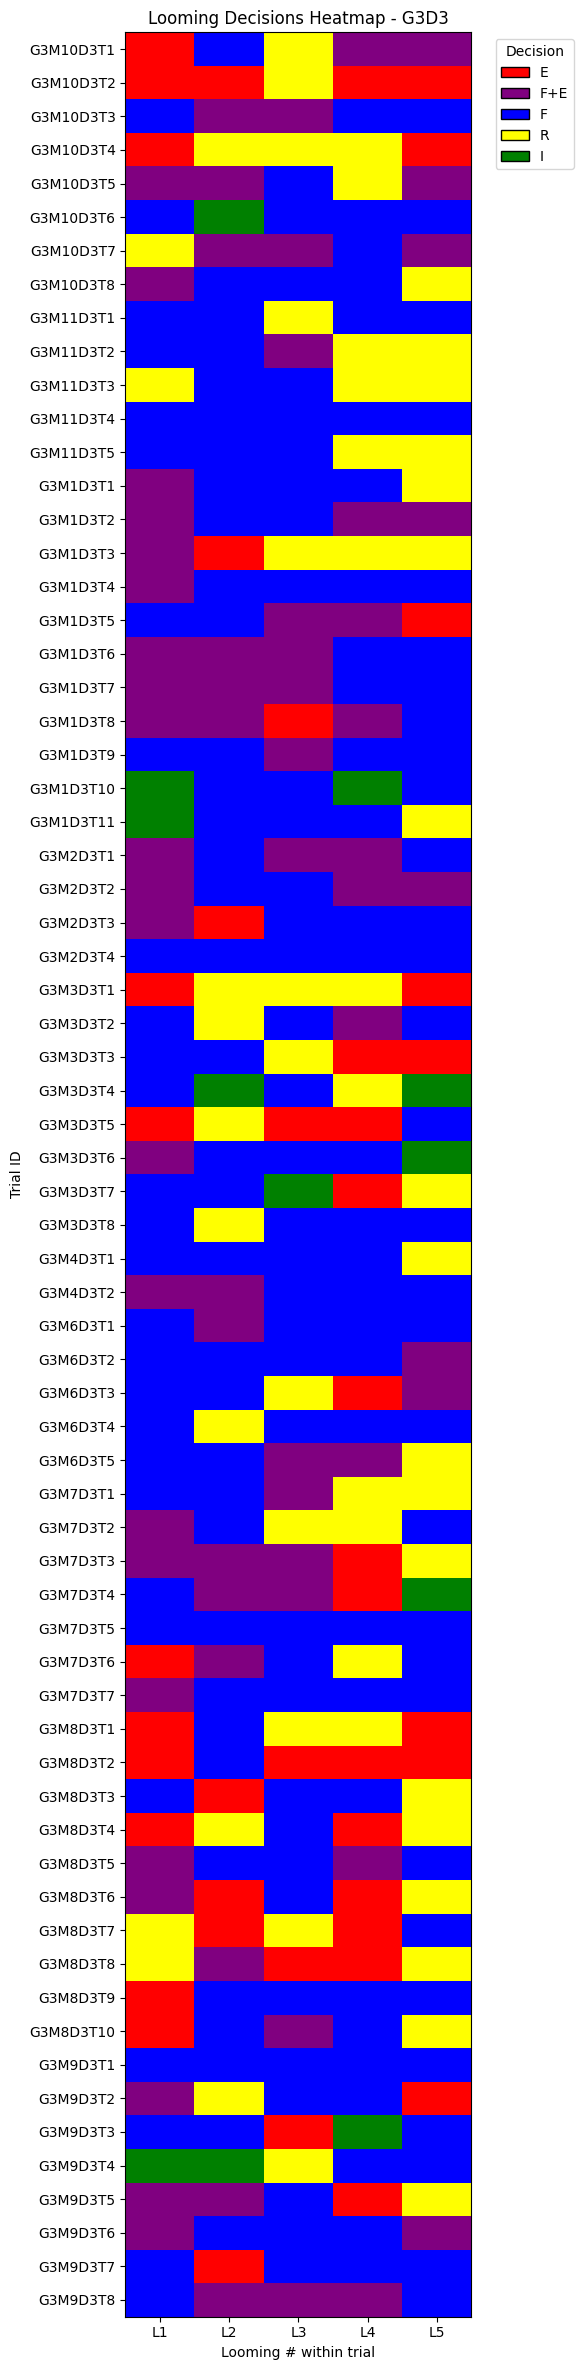

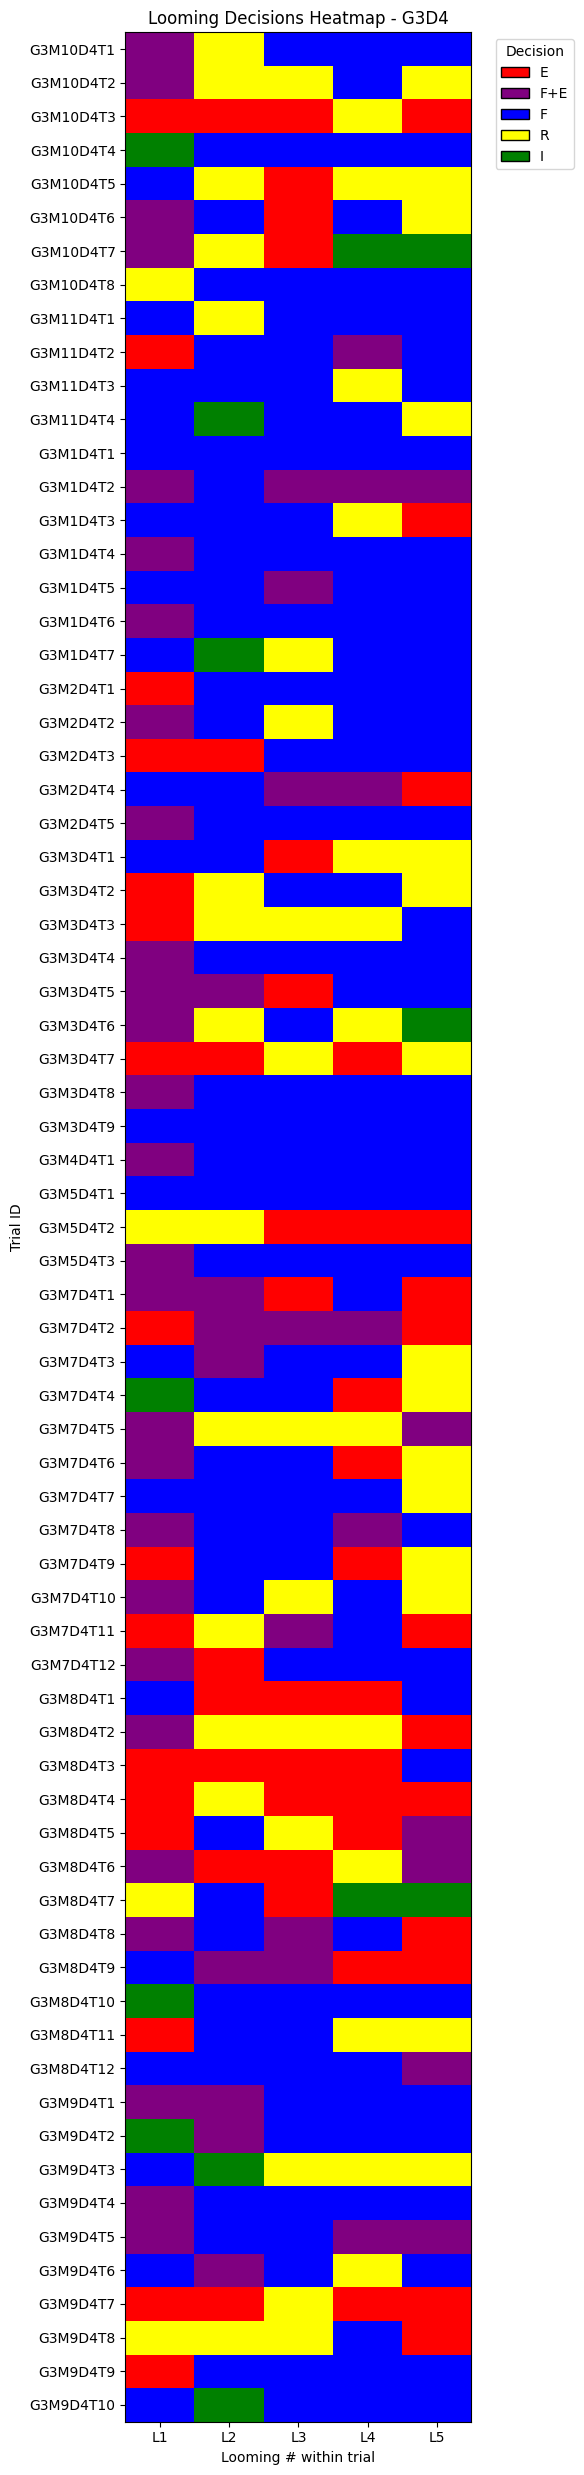

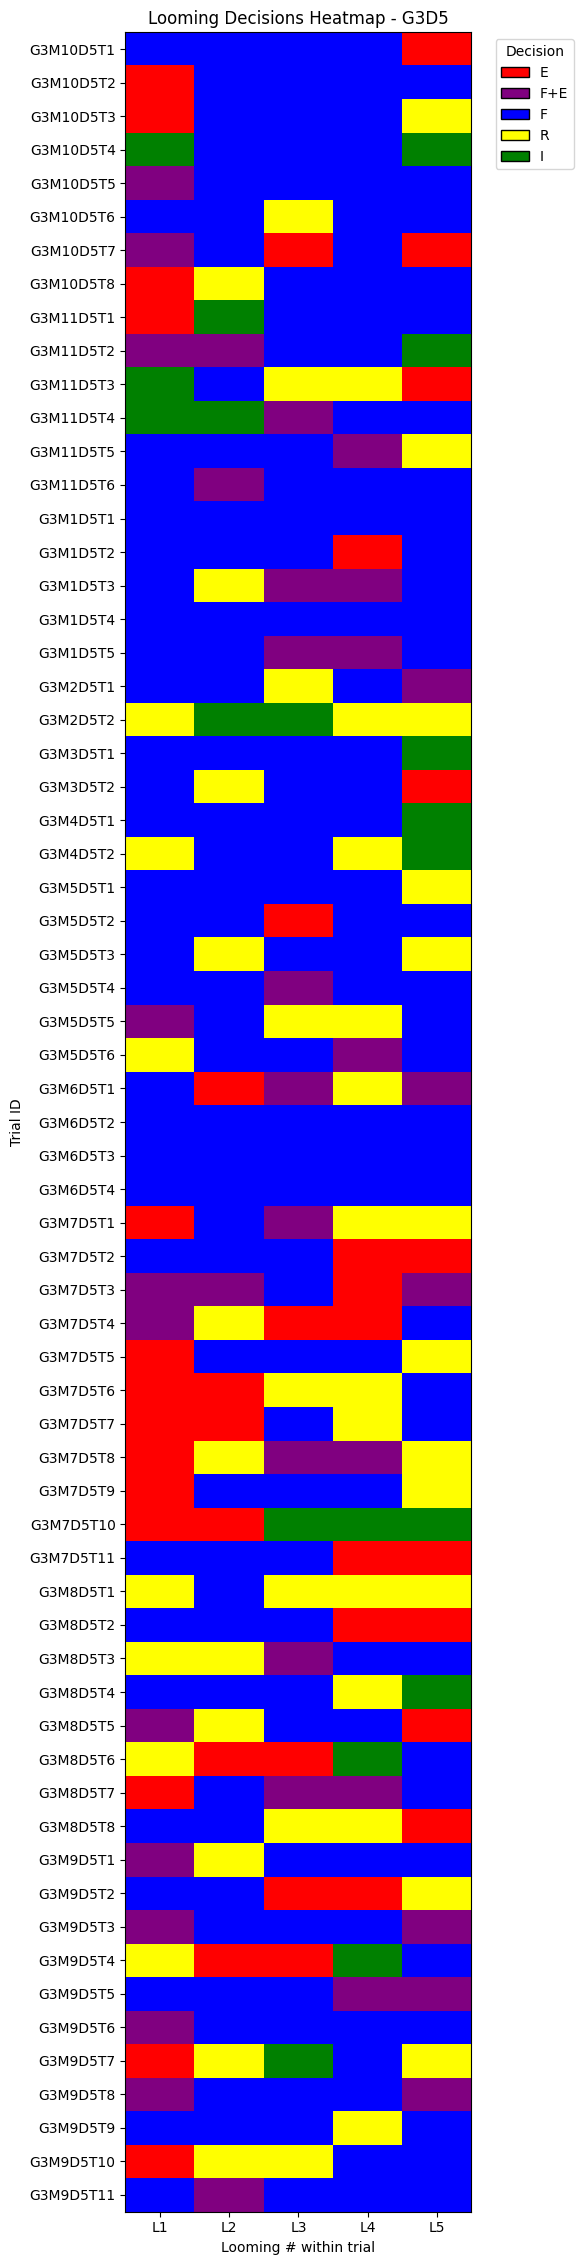

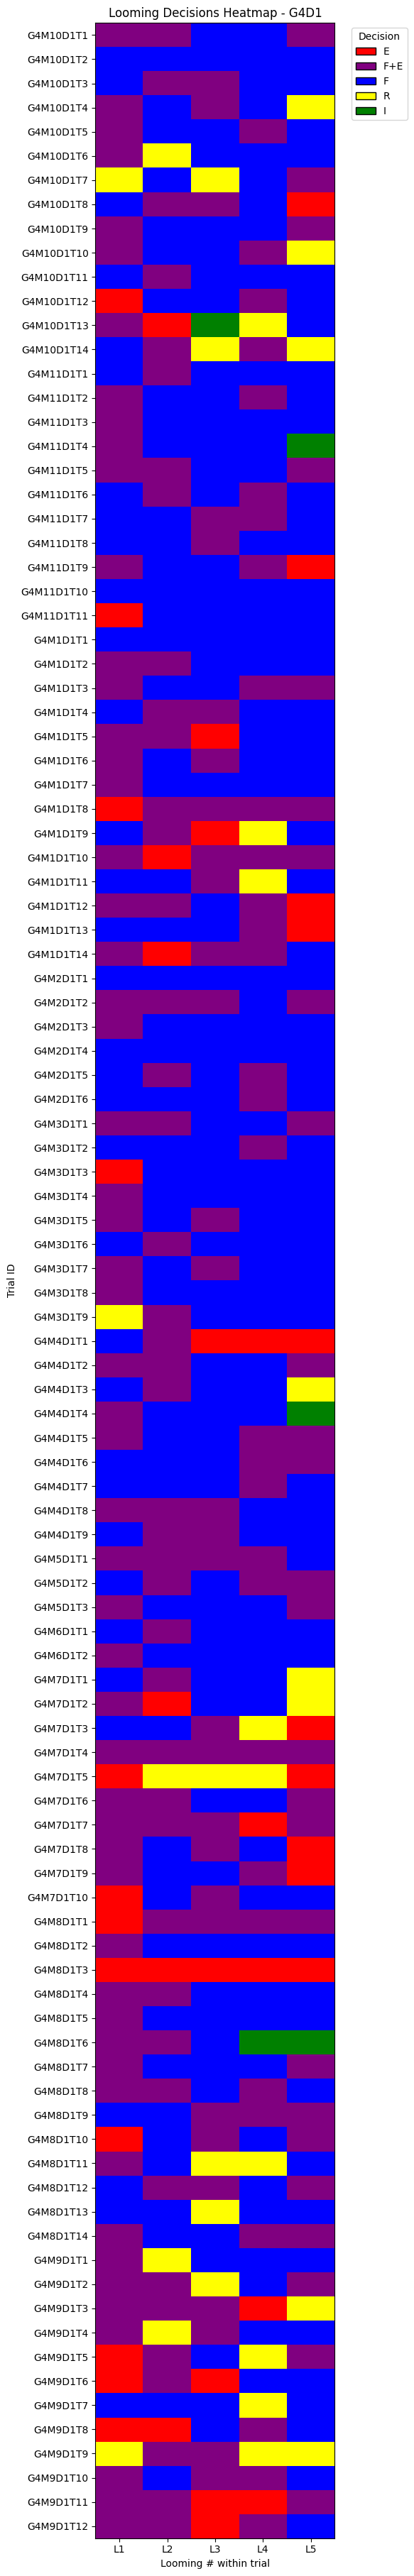

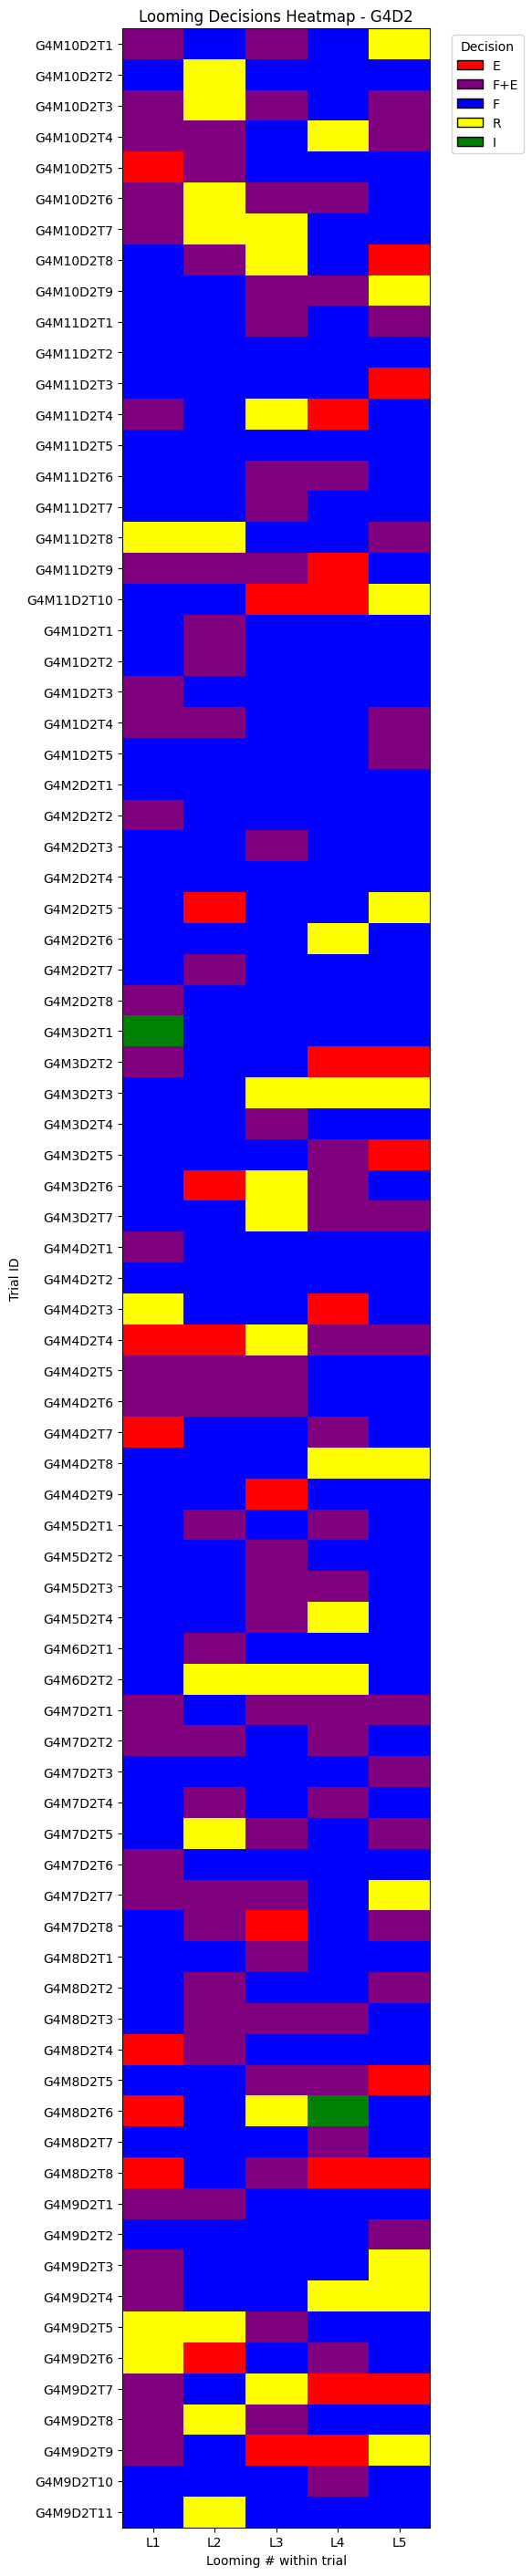

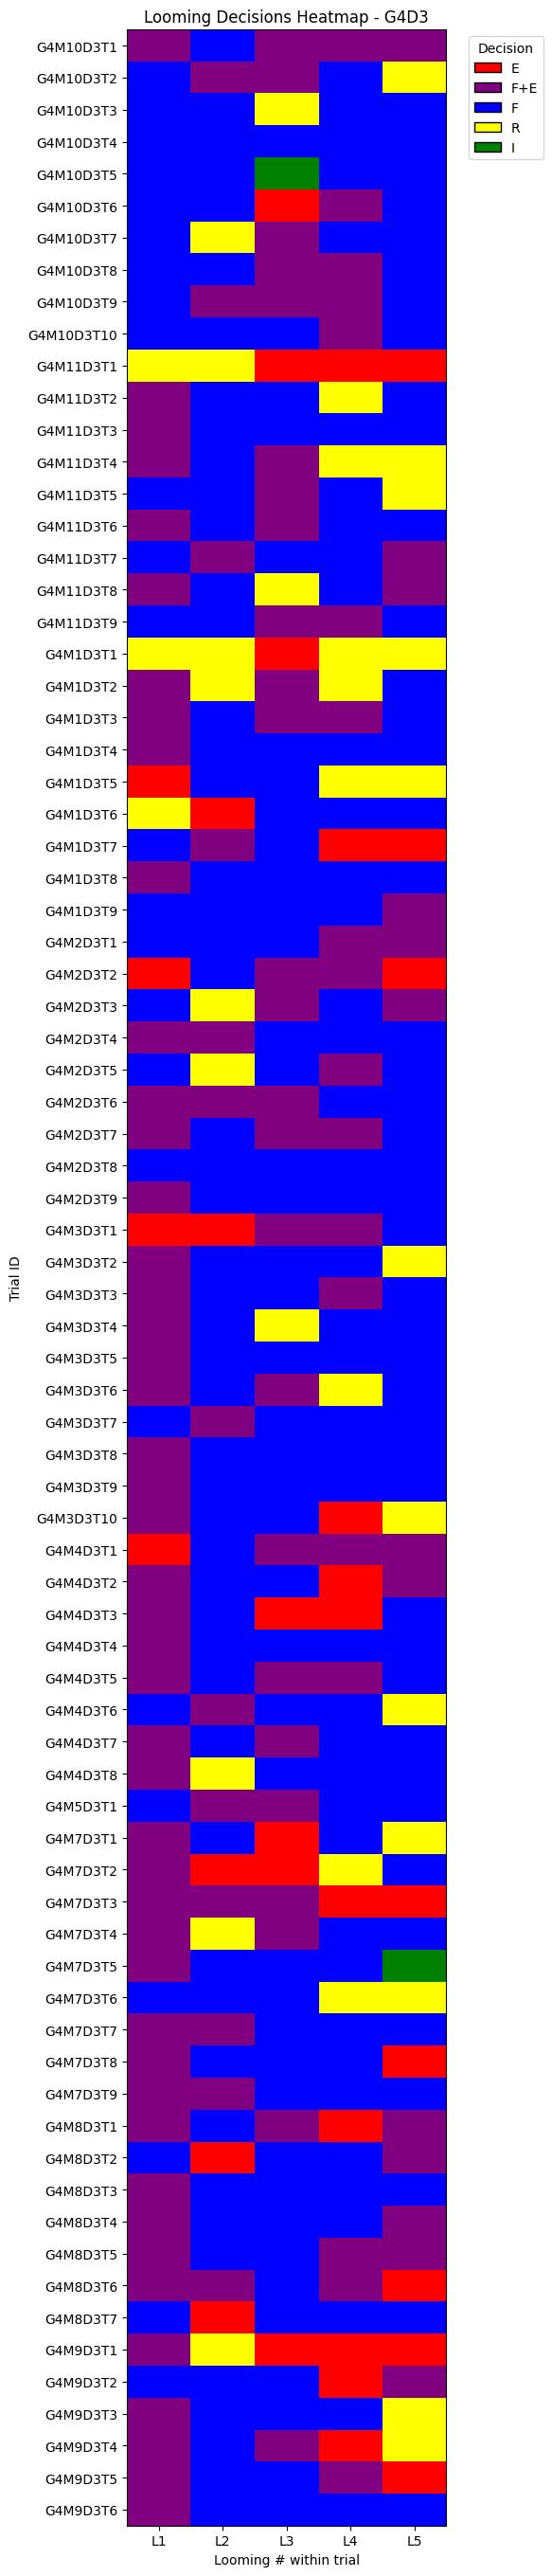

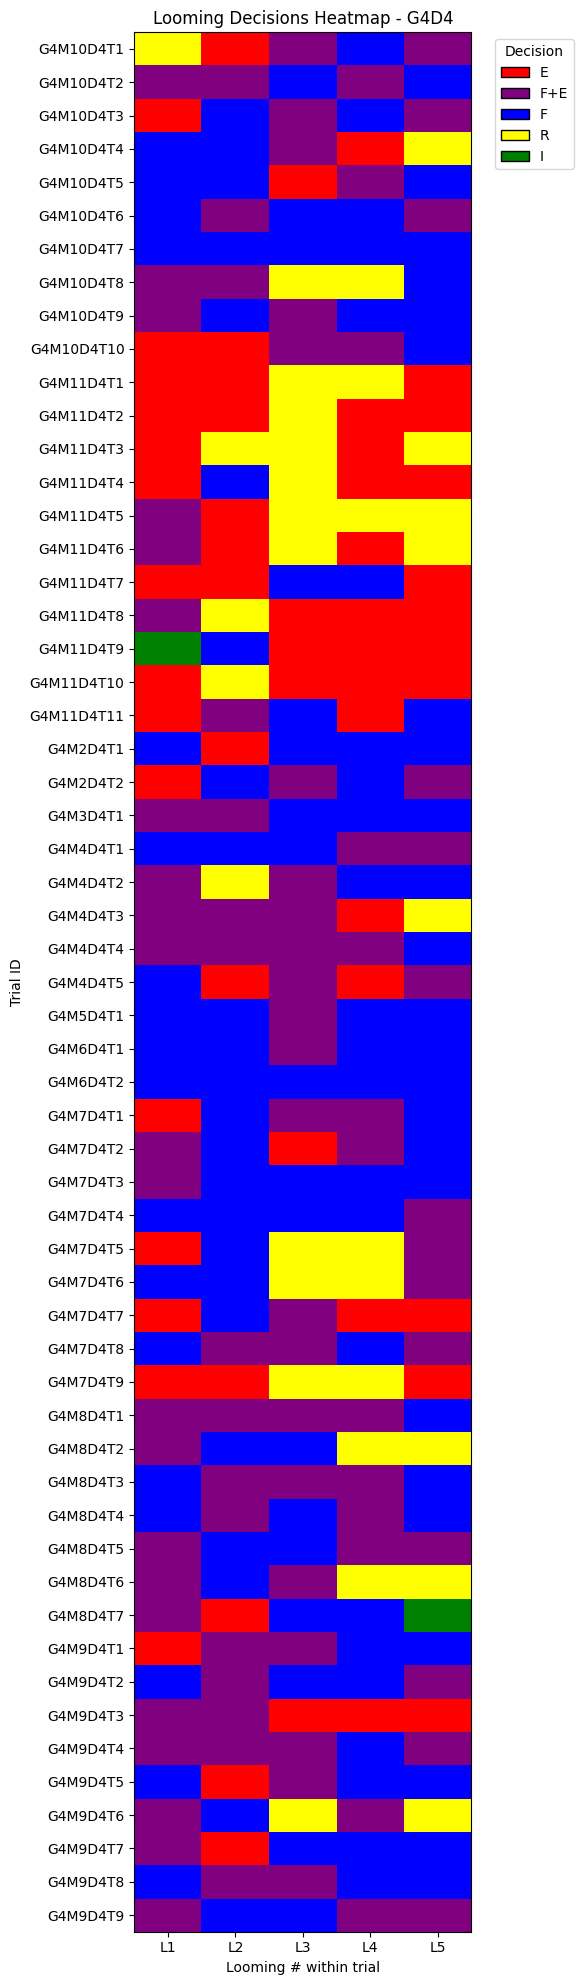

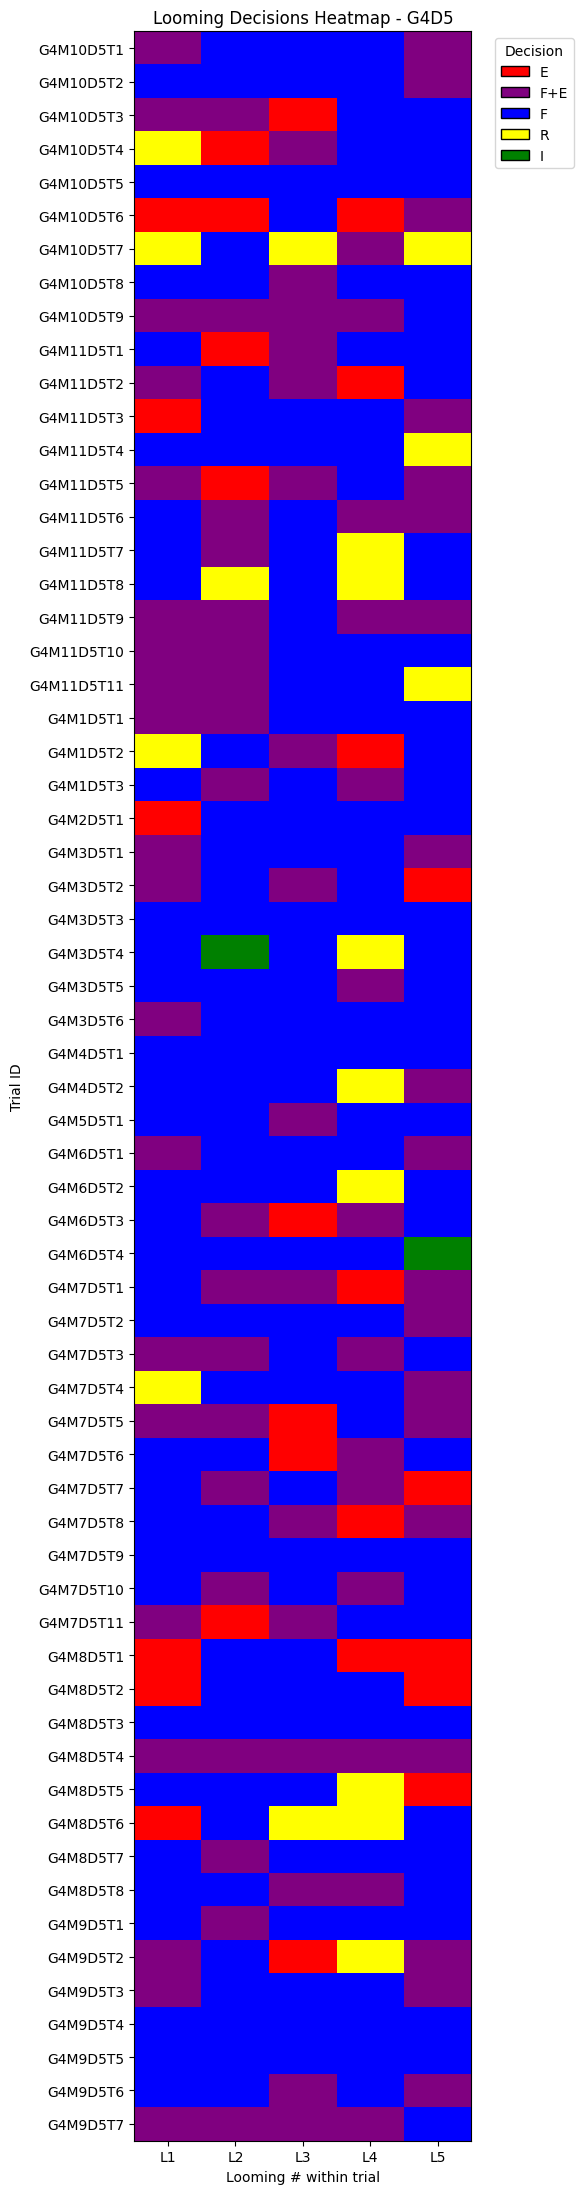

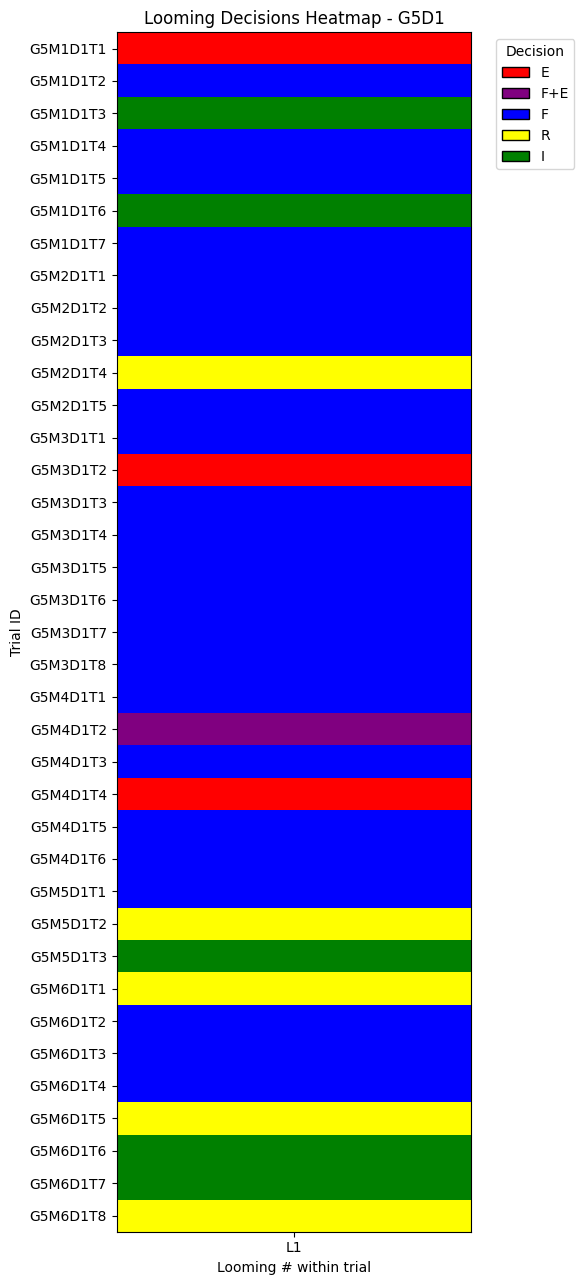

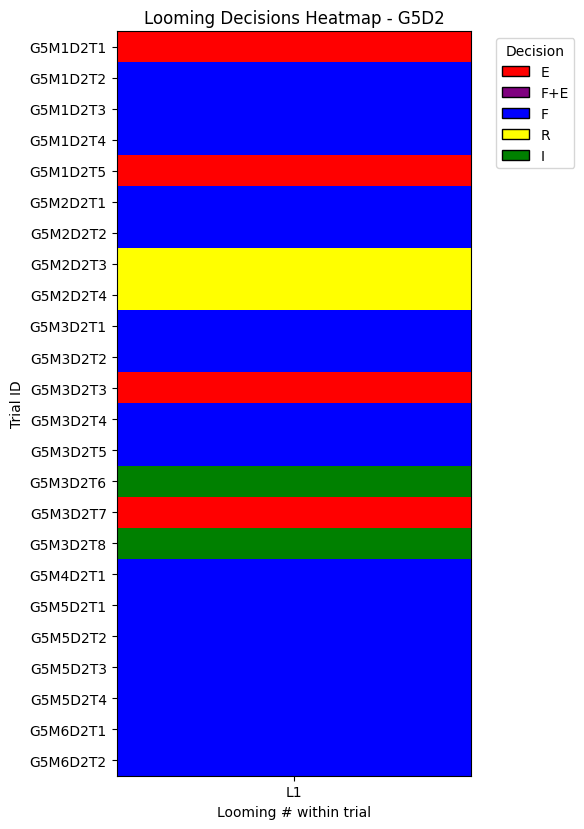

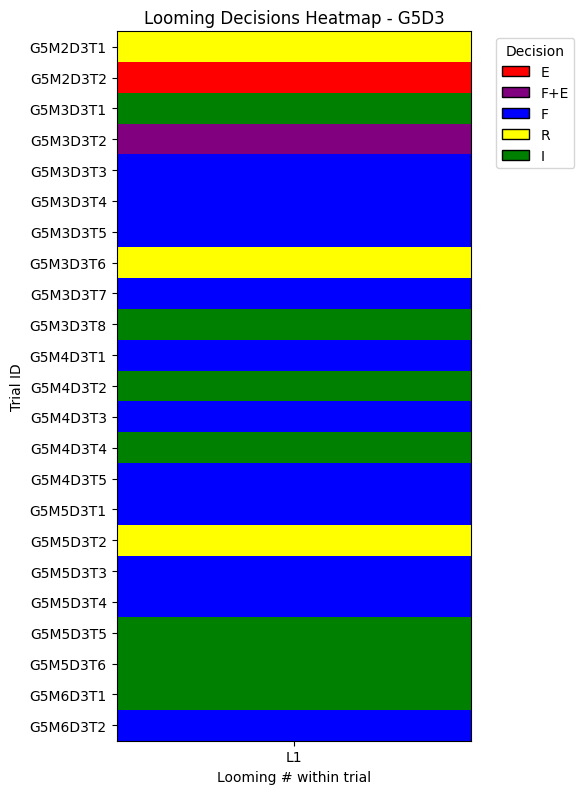

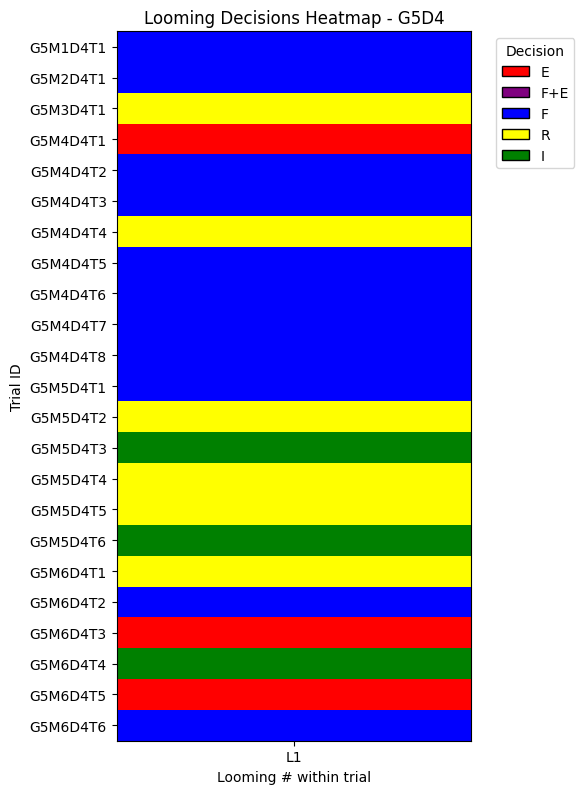

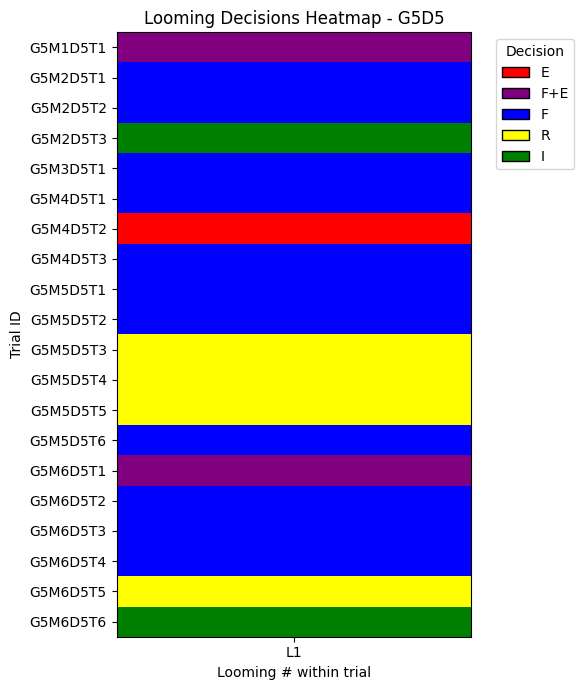

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from collections import defaultdict
from matplotlib.patches import Patch

# Visualize looming decisions as heatmaps, one figure per G-D (group-day)
decision_to_code = {
    'E': 0,
    'F+E': 1,
    'F': 2,
    'R': 3,
    'I': 4,
}
code_to_label = ['E', 'F+E', 'F', 'R', 'I']
colors = ['red', 'purple', 'blue', 'yellow', 'green']
cmap = ListedColormap(colors)
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)
legend_handles = [Patch(facecolor=colors[i], edgecolor='black', label=code_to_label[i]) for i in range(len(code_to_label))]

# Group trials by G and D
group_trials = defaultdict(list)
for sess_id, trials in deci_looming_dict.items():
    g = sess_id.split('M')[0].replace('G', '')  # e.g., G1M1D1 -> '1'
    d = sess_id.split('D')[1]                    # e.g., G1M1D1 -> '1'
    group_key = f"G{g}D{d}"
    for trial_id, decisions in trials.items():
        group_trials[group_key].append((trial_id, decisions))

for gd_key, gd_trials in sorted(group_trials.items(), key=lambda kv: (int(kv[0].split('D')[0].replace('G', '')), int(kv[0].split('D')[1]))):
    if len(gd_trials) == 0:
        continue

    rows = []
    row_labels = []
    max_looms = 0
    for trial_id, decisions in gd_trials:
        row_labels.append(trial_id)
        rows.append(decisions)
        max_looms = max(max_looms, len(decisions))

    if max_looms == 0:
        continue

    data = np.full((len(rows), max_looms), np.nan)
    for i, decs in enumerate(rows):
        for j, dec in enumerate(decs):
            data[i, j] = decision_to_code.get(dec, np.nan)

    masked_data = np.ma.masked_invalid(data)

    fig, ax = plt.subplots(figsize=(max(6, max_looms * 0.8), max(6, len(rows) * 0.35)))
    ax.imshow(masked_data, cmap=cmap, norm=norm, aspect='auto')

    ax.set_xticks(np.arange(max_looms))
    ax.set_xticklabels([f'L{j+1}' for j in range(max_looms)])
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xlabel('Looming # within trial')
    ax.set_ylabel('Trial ID')
    ax.set_title(f'Looming Decisions Heatmap - {gd_key}')

    ax.legend(handles=legend_handles, title='Decision', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    plt.show()

## TODO: Modelling

***Drifting Diffusion Leaky Integrator Model***

The animal's decision-making process in response to the looming stimulus during foraging is modeled as a drifting diffusion leaky integrator. An escape decision is initiated when the accumulated evidence level crosses a threshold.

---

***Evidence Accumulation Dynamics***

$$\frac{dx_i}{dt} = -\alpha \cdot x_i(t) + h_i \cdot \beta \cdot s(t) - r + \delta \cdot \frac{dW}{dt} \qquad (1)$$

$$E(t) = \mathcal{H}(x_i(t) - x_{thr}) \qquad (2)$$

where $x_i(t)$ is the evidence level to escape at time $t$ for $i$ th trial; $\alpha$ is the leaky component that drives the evidence level to zero and is the reciprocal of the time constant; $s(t)$ is the normalized diameter of the looming stimulus; $\beta$ is a free parameter that modulates the perceived threat value and is related to the stimulus contrast; $h_i$ is the habituation parameter; $r$ is the perceived reward value; $W(t)$ is a Wiener process, and $W(t + \Delta t) - W(t) \sim \mathcal{N}(0, \Delta t)$. $E(t)$ is the escape decision and $\mathcal{H}$ is the Heaviside step function.

---

***Habituation Function***

Because the animal exhibits rapid habituation to the looming stimulus for the first five trials, followed by a slower adaptation phase, the habituation effect is modeled as a sum of fast and slow components:

$$h_i = (e^{-tr_i/\tau_f} + e^{-tr_i/\tau_s})/2 \qquad (3)$$

where $tr_i$ is the $i$th trial, $\tau_f$ is the fast decay component, and $\tau_s$ is the slow decay component.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters, Minimizer, report_fit

# DDLI Model with lmfit and dual thresholds (freezing, escape)
np.random.seed(42)

# Design
looming_duration = 0.5
n_loomings = 5

# Time
dt = 0.01
T = 30.0
# Start curves from -5s
t = np.arange(-5, T, dt)

# Initial defaults and thresholds
default_params = {
    'alpha': 0.20,
    'beta': 3.0,
    'r': 0.0,
    'delta': 0.3,
    'x0': 0.0,
    'tau_f': 2.0,
    'tau_s': 10.0,
}
# Dual thresholds
x_thr_freeze = 0.75
x_thr_escape = 1.0

# ISI set and targets (escape %)
ISI_conditions = [0.0, 0.5, 1.0, 3.0]
escape_targets = {0.0: 80.0, 0.5: 50.0, 1.0: 40.0, 3.0: 10.0}

# Stimulus (linear ramp)
def looming_stimulus(time_array, looming_times, duration=0.5):
    stim = np.zeros_like(time_array)
    for loom_t in looming_times:
        mask = (time_array >= loom_t) & (time_array < loom_t + duration)
        rel = np.where(mask, time_array - loom_t, 0)
        stim += mask * (rel / duration)
    return stim

# Habituation factor
def habituation_factor(past_times, current_time, tau_f, tau_s):
    if len(past_times) == 0:
        return 1.0
    diffs = current_time - np.array(past_times)
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return 1.0
    h = np.mean([(np.exp(-d / tau_f) + np.exp(-d / tau_s)) / 2 for d in diffs])
    return np.clip(h, 0.0, 1.0)

# Single trial
def run_single_trial(looming_times, pars):
    alpha = pars['alpha']
    beta = pars['beta']
    r = pars['r']
    delta = pars['delta']
    x0 = pars['x0']
    tau_f = pars['tau_f']
    tau_s = pars['tau_s']

    stim = looming_stimulus(t, looming_times, looming_duration)
    x = np.zeros_like(t)
    xi = x0
    for i in range(len(t)):
        past_loomings = [lt for lt in looming_times if lt < t[i]]
        h_i = habituation_factor(past_loomings, t[i], tau_f, tau_s)
        dW = np.random.randn() * np.sqrt(dt)
        dx = -alpha * xi + h_i * beta * stim[i] - r + delta * dW
        xi = xi + dx * dt
        x[i] = xi
    return x

# Compute freezing/escape for a trial trace
def classify_trial(x_trace, looming_times):
    decision = {'freeze': np.zeros(len(looming_times), dtype=bool),
                'escape': np.zeros(len(looming_times), dtype=bool)}
    for idx, lt in enumerate(looming_times):
        window = (t >= lt) & (t < lt + 3.0)
        xw = x_trace[window]
        # escape if crossing escape threshold
        if np.any(xw >= x_thr_escape):
            decision['escape'][idx] = True
            continue
        # else freezing if crossing freezing threshold
        if np.any(xw >= x_thr_freeze):
            decision['freeze'][idx] = True
    return decision

# Simulate escape rate for an ISI
def simulate_escape_rate(ISI, pars, n_trials=100):
    looming_times = [3.0 + i * (looming_duration + ISI) for i in range(n_loomings)]
    escapes = np.zeros(n_loomings)
    for _ in range(n_trials):
        x_tr = run_single_trial(looming_times, pars)
        dec = classify_trial(x_tr, looming_times)
        escapes += dec['escape'].astype(int)
    return (escapes / n_trials) * 100.0

# lmfit parameters (global across ISIs)
params = Parameters()
params.add('alpha', value=default_params['alpha'], min=0.05, max=2.0)
params.add('beta', value=default_params['beta'], min=0.5, max=8.0)
params.add('r', value=default_params['r'], min=-0.5, max=0.5)
params.add('delta', value=default_params['delta'], min=0.05, max=1.0)
params.add('x0', value=default_params['x0'], min=-0.5, max=0.5)
params.add('tau_f', value=default_params['tau_f'], min=0.1, max=10.0)
params.add('tau_s', value=default_params['tau_s'], min=0.3, max=30.0)

# Residual: stack differences of escape rates across targeted ISIs

def residual(pars):
    p = {k: pars[k].value for k in pars.keys()}
    res_list = []
    for ISI in ISI_conditions:
        esc_rates = simulate_escape_rate(ISI, p, n_trials=60)
        # average escape across the 5 loomings for the condition
        esc_avg = esc_rates.mean()
        target = escape_targets[ISI]
        res_list.append(esc_avg - target)
    return np.array(res_list)

# Optimize
result = Minimizer(residual, params).minimize(method='least_squares')
fit_pars = {k: result.params[k].value for k in result.params.keys()}

print('=== Fit Report (escape probabilities across ISIs) ===')
report_fit(result)
print('Fitted parameters:')
for k, v in fit_pars.items():
    print(f'  {k}: {v:.4f}')




=== Fit Report (escape probabilities across ISIs) ===
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 8
    # data points      = 4
    # variables        = 7
    chi-square         = 6600.00000
    reduced chi-square = 6600.00000
    Akaike info crit   = 43.6341223
    Bayesian info crit = 39.3381828
##  Warning: uncertainties could not be estimated:
    alpha:  at initial value
    beta:   at initial value
    delta:  at initial value
    tau_f:  at initial value
    tau_s:  at initial value
[[Variables]]
    alpha:  0.20000000 (init = 0.2)
    beta:   3.00000000 (init = 3)
    r:      0.00000000 (init = 0)
    delta:  0.30000000 (init = 0.3)
    x0:     0.00000000 (init = 0)
    tau_f:  2.00000000 (init = 2)
    tau_s:  10.0000000 (init = 10)
Fitted parameters:
  alpha: 0.2000
  beta: 3.0000
  r: 0.0000
  delta: 0.3000
  x0: 0.0000
  tau_f: 2.0000
  tau_s: 10.0000


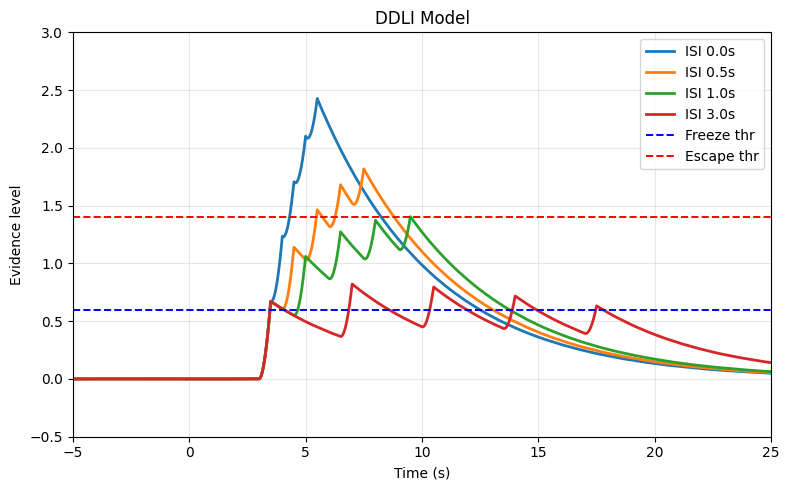

In [ ]:
# Plot combined evidence curves across ISIs (freeze & escape thresholds indicated)
fig, ax = plt.subplots(figsize=(8, 5))

for ISI in ISI_conditions:
    looming_times = [3.0 + i * (looming_duration + ISI) for i in range(n_loomings)]
    traces = []
    for _ in range(100):
        x_tr = run_single_trial(looming_times, fit_pars)
        traces.append(x_tr)
    traces = np.array(traces)
    mean_e = traces.mean(axis=0)
    sem_e = traces.std(axis=0, ddof=1) / np.sqrt(len(traces))

    ax.plot(t, mean_e, lw=2, label=f'ISI {ISI}s')
    ax.fill_between(t, mean_e - sem_e, mean_e + sem_e, alpha=0.18)

# Threshold lines
ax.axhline(0.6, color='blue', ls='--', lw=1.4, label='Freeze thr')
ax.axhline(1.4, color='red', ls='--', lw=1.4, label='Escape thr')

# Set requested x-axis range and ticks
ax.set_xlim(-5, 25)
ax.set_ylim(-0.5, 3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Evidence level')
ax.set_title('DDLI Model')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()